In [225]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.optim as optim
from torch.autograd import Variable
from typing import Dict, Any, Tuple, Union, NamedTuple
import hydra

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 1e-3
max_steps = 1000
print_freq = 100


torch.manual_seed(995)

In [226]:
# ============================================================================
# Physical Constants (unchanged)
# ============================================================================
lc = 1e-9
cc = 1e-5
F = 96485  # Faraday constant [C/mol]
R = 8.3145  # Gas constant [J/(mol·K)]
T = 293  # Temperature [K]
k_B = 1.3806e-23  # Boltzmann constant [J/K]
eps0 = 8.85e-12  # Vacuum permittivity [F/m]
E_min = -1.0  # External applied potential [V]
E_max = 1.8

# Diffusion coefficients [m²/s]
D_cv = 1.0e-21
D_av = 1.0e-21
D_h = 3.2823e-4

# Mobility coefficients [m²/(V·s)]
U_cv = -1.0562e-19
U_av = 7.9212e-20
U_h = 0.013

# Species charges
z_cv = -2.6667  # -8/3
z_av = 2
z_h = 1

# Permittivities [F/m]
epsilonf = 1.239e-10  # 14*eps0 (film)
eps_film = 1.239e-10  # Same as epsilonf

# ============================================================================
# UPDATED: Double Defect Layer Structure
# Metal | ddl₁ | Film | ddl₂ | cdl | Solution
# ============================================================================

# Metal side (ddl₁) - in the metal, affects BC at x=0
eps_dl1 = 1.77e-11  # 2*eps0 (defect layer at metal side)
d_dl1 = 2.0e-10  # Thickness [m]

# Solution side (ddl₂) - between film and compact layer
eps_dl2 = 1.77e-11  # 2*eps0 (defect layer at solution side)
d_dl2 = 2.0e-10  # Thickness [m]

# Compact double layer (cdl) - Helmholtz layer
eps_cdl = 6.947e-10  # 78.5*eps0 (compact layer permittivity)
d_cdl = 5.0e-10  # Thickness [m]

# Dimensionless parameters
Lambda_dl1 = eps_dl1 / eps_film  # ε_dl1 / ε_F ≈ 0.143
Lambda_dl2 = eps_film / eps_dl2  # ε_F / ε_dl2 ≈ 7.0
Lambda_cdl = eps_film / eps_cdl  # ε_F / ε_cdl ≈ 0.178

d_dl1_hat = d_dl1 / lc  # ≈ 0.2
d_dl2_hat = d_dl2 / lc  # ≈ 0.2
d_cdl_hat = d_cdl / lc  # ≈ 0.5

# ============================================================================
# Remaining parameters (unchanged)
# ============================================================================
eps_sol = 6.947e-10  # Solution permittivity

# Semiconductor properties
c_h0 = 4.1683e-4
c_e0 = 9.5329e-28
tau = 4.9817e-13
Nc = 166.06
Nv = 1.6606e5
mu_e0 = 2.4033e-19
Ec0 = 5.127e-19
Ev0 = 1.6022e-19

# Solution properties
c_H = 0.01
pH = 5

# Molar volume
Omega = 1.4e-5

# Standard rate constants
k1_0 = 4.5e-8
k2_0 = 3.6e-6
k3_0 = 4.5e-9
k4_0 = 2.25e-7
k5_0 = 7.65e-9
ktp_0 = 4.5e-8
ko2_0 = 0.005

# Charge transfer coefficients
alpha_cv = 0.3
alpha_av = 0.8
beta_cv = 0.1
beta_av = 0.8
alpha_tp = 0.2
a_par = 0.45
delta3 = 1.0

# Derived parameters [1/V]
a_cv = 23.764
a_av = 84.493
b_cv = 7.9212

# Derived constants
phic = (R * T) / F  # ≈ 0.0253 V
tc = (lc ** 2) / D_cv  # ≈ 1000 s
L_initial = 1e-10
time_scale = 9000000  # 250 Hours in Seconds

In [227]:
#Define networks

class Swish(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self,x):
        return torch.sigmoid(x)*x


class FFN(nn.Module):
    """
    Fully Connected Feed Forward Neural Network.
    Args:
        input_dim: Number of input features
        output_dim: Number of output features
        hidden_layers: Number of hidden layers
        layer_size: Size of each hidden layer
        activation: Activation function name ('swish', 'swoosh', 'swash', 'squash_swish', 'relu', 'tanh')
        initialize_weights: Whether to apply Xavier initialization
    """
    def __init__(
        self,
        input_dim: int = 3,
        output_dim: int = 1,
        hidden_layers: int = 5,
        layer_size: int = 20,
        activation: str = "swish",
        initialize_weights: bool = False
    ):
        super(FFN, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = hidden_layers
        self.layer_size = layer_size
        self.activation = Swish()

        # Input layer
        self.input_layer = nn.Linear(input_dim, self.layer_size)

        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(self.layer_size, self.layer_size)
            for _ in range(self.num_layers)
        ])

        # Output layer
        self.output_layer = nn.Linear(self.layer_size, output_dim)

        # Initialize weights
        if initialize_weights:
            self.initialize_weights()

    def initialize_weights(self):
        """Apply Xavier initialization to all linear layers"""
        # Initialize input layer
        nn.init.xavier_normal_(self.input_layer.weight)
        nn.init.zeros_(self.input_layer.bias)

        # Initialize hidden layers
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

        # Initialize output layer
        nn.init.xavier_normal_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, x):
        x = self.activation(self.input_layer(x))

        for layer in self.hidden_layers:
            x = self.activation(layer(x))

        return self.output_layer(x)


class ResidualBlock(nn.Module):
    """Single residual block: x + F(x)"""
    def __init__(self, layer_size, activation):
        super(ResidualBlock, self).__init__()
        self.layer_size = layer_size
        self.activation = activation

        # Two layers in each residual block
        self.linear1 = nn.Linear(layer_size, layer_size)
        self.linear2 = nn.Linear(layer_size, layer_size)

    def initialize_weights(self):
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        nn.init.xavier_normal_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)

    def forward(self, x):
        identity = x  # Save input for residual connection

        # F(x) computation
        out = self.activation(self.linear1(x))
        out = self.linear2(out)  # No activation on final layer of block

        # Residual connection: x + F(x)
        out = out + identity

        # Activation after residual connection
        out = self.activation(out)

        return out

class ResidualFFN(nn.Module):
    def __init__(self, input_dim=3, output_dim=1, num_layers=8, layer_size=50, initialize_weights=True):
        super(ResidualFFN, self).__init__()
        self.layer_size = layer_size
        self.num_layers = num_layers
        self.activation = Swish()

        # Input projection to get to residual dimension
        self.input_layer = nn.Linear(input_dim, self.layer_size)

        # Residual blocks
        self.residual_layers = nn.ModuleList([
            ResidualBlock(self.layer_size, self.activation)
            for _ in range(self.num_layers)
        ])

        # Output layer
        self.output_layer = nn.Linear(self.layer_size, output_dim)

        if initialize_weights:
            self.initialize_weights()

    def initialize_weights(self):
        """Apply Xavier initialization to all linear layers"""
        nn.init.xavier_normal_(self.input_layer.weight)
        nn.init.zeros_(self.input_layer.bias)

        for block in self.residual_layers:
            block.initialize_weights()

        nn.init.xavier_normal_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, x):
        # Input projection
        x = self.activation(self.input_layer(x))

        # Residual blocks
        for residual_layer in self.residual_layers:
            x = residual_layer(x)

        # Output
        return self.output_layer(x)

"""
cv_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20) #ResNet Size as close to old FFN as possible. There is one extra layer here by nature of design.
av_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20)
u_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20)
L_net = ResidualFFN(input_dim=2, output_dim=1, num_layers=3, layer_size=20)
"""
cv_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20) #ResNet Size as close to old FFN as possible. There is one extra layer here by nature of design.
av_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20)
u_net = ResidualFFN(input_dim=3, output_dim=1, num_layers=3, layer_size=20)
L_net = ResidualFFN(input_dim=2, output_dim=1, num_layers=3, layer_size=20)
cv_net.to(device)
av_net.to(device)
u_net.to(device)
L_net.to(device)

total_model_parameters = list(cv_net.parameters()) + list(av_net.parameters()) + list(u_net.parameters()) + list(L_net.parameters())

In [228]:

class GradientResults(NamedTuple):
    """
    Container for gradient computation results.

    Organizes all computed derivatives in a structured way for easy access.
    """
    # Network predictions
    phi: torch.Tensor  # Potential φ
    c_cv: torch.Tensor  # Cation vacancy concentration
    c_av: torch.Tensor  # Anion vacancy concentration

    # Time derivatives
    c_cv_t: torch.Tensor  # ∂c_cv/∂t
    c_av_t: torch.Tensor  # ∂c_av/∂t

    # First spatial derivatives
    phi_x: torch.Tensor  # ∂φ/∂x
    c_cv_x: torch.Tensor  # ∂c_cv/∂x
    c_av_x: torch.Tensor  # ∂c_av/∂x

    # Second spatial derivatives
    phi_xx: torch.Tensor  # ∂²φ/∂x²
    c_cv_xx: torch.Tensor  # ∂²c_cv/∂x²
    c_av_xx: torch.Tensor  # ∂²c_av/∂x²


def _grad(x, dx):
    """Take the derivative of x w.r.t dx"""
    return torch.autograd.grad(
        x, dx,
        torch.ones_like(x),  #  CHANGE: Use x instead of dx for grad_outputs
        create_graph=True,
        retain_graph=True
    )[0]


def compute_gradients(x, t, E):
    inputs_3d = torch.cat([x, t, E], dim=1)

    # Get network predictions
    phi = u_net(inputs_3d)
    c_cv_raw = cv_net(inputs_3d)
    c_av_raw = av_net(inputs_3d)

    # Networks predict concentrations directly
    c_cv = c_cv_raw
    c_av = c_av_raw

    # Direct derivatives
    c_cv_t = _grad(c_cv, t)
    c_av_t = _grad(c_av, t)

    # Compute first spatial derivatives
    phi_x = _grad(phi, x)
    c_cv_x = _grad(c_cv, x)
    c_av_x = _grad(c_av, x)

    # Compute second spatial derivatives
    phi_xx = _grad(phi_x, x)
    c_cv_xx = _grad(c_cv_x, x)
    c_av_xx = _grad(c_av_x, x)

    return GradientResults(
        phi=phi, c_cv=c_cv, c_av=c_av,
        c_cv_t=c_cv_t, c_av_t=c_av_t,
        phi_x=phi_x, c_cv_x=c_cv_x, c_av_x=c_av_x,
        phi_xx=phi_xx, c_cv_xx=c_cv_xx, c_av_xx=c_av_xx
    )


def sample_interior_points() -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Sample interior collocation points for PDE residuals.

    Returns:
        Tuple of (x, t, E) tensors with requires_grad=True for x and t
    """
    batch_size = 2048

    # Sample time and applied potential
    t = torch.rand(batch_size, 1, device=device, requires_grad=True) * time_scale / tc
    single_E = (
        torch.rand(1, 1, device=device)
        * (E_max - E_min)
        + E_min
    )
    E = single_E.expand(batch_size, 1).requires_grad_(True)  #  CHANGE

    # Get film thickness prediction
    L_pred = L_net(torch.cat([t, E], dim=1))

    # Sample spatial coordinates within [0, L(t,E)]
    x = (
        torch.rand(batch_size, 1, device=device, requires_grad=True)
        * L_pred.detach()  #  CHANGE
    )

    return x, t, E

def sample_initial_points() -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Sample initial condition points at t = 0.

    Returns:
        Tuple of (x, t, E) tensors for initial condition points
    """
    batch_size = 1024

    # Initial time (t = 0)
    t = torch.zeros(batch_size, 1, device=device, requires_grad=True)
    single_E = (
        torch.rand(1, 1, device=device)
        * (E_max - E_min)
        + E_min
    )
    E = single_E.expand(batch_size, 1).requires_grad_(True)  #  CHANGE

    # Get initial film thickness
    L_initial_pred = L_net(torch.cat([t, E], dim=1))

    # Sample spatial coordinates within [0, L(t=0, E)]
    x = (
        torch.rand(batch_size, 1, device=device, requires_grad=True)
        * L_initial_pred.detach()  #  CHANGE
    )

    return x, t, E
def sample_boundary_points() -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Sample boundary collocation points for boundary conditions.

    Returns:
        Tuple of (x, t, E) tensors for boundary points
    """
    batch_size = 2 * 1024

    # Sample time and applied potential
    t = torch.rand(batch_size, 1, device=device, requires_grad=True)
    single_E = (
        torch.rand(1, 1, device=device)
        * (E_max - E_min)
        + E_min
    )
    E = single_E.expand(batch_size, 1).requires_grad_(True)  #  Added

    # Predict L for f/s boundary
    L_inputs = torch.cat([t, E], dim=1)
    L_pred = L_net(L_inputs)

    half_batch = batch_size // 2

    # Metal/film interface points (x = 0)
    x_mf = torch.zeros(half_batch, 1, device=device, requires_grad=True)
    t_mf = t[:half_batch]
    E_mf = E[:half_batch]

    # Film/solution interface points (x = L)
    x_fs = L_pred[half_batch:].requires_grad_(True)  #  Added
    t_fs = t[half_batch:]
    E_fs = E[half_batch:]

    # Combine boundary points
    x_boundary = torch.cat([x_mf, x_fs], dim=0)
    t_boundary = torch.cat([t_mf, t_fs], dim=0)
    E_boundary = torch.cat([E_mf, E_fs], dim=0)

    return x_boundary, t_boundary, E_boundary

def sample_film_physics_points() -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Sample points for film growth physics constraint.

    Returns:
        Tuple of (t, E) tensors for film physics constraint
    """
    batch_size = 2048

    # Sample time and applied potential
    t = torch.rand(batch_size, 1, device=device, requires_grad=True)
    single_E = (
        torch.rand(1, 1, device=device)
        * (E_max - E_min)
        + E_min
    )
    E = single_E.expand(batch_size, 1).requires_grad_(True)  #  CHANGE

    return t, E

In [229]:
#Compute and generate all the relevant losses

def compute_rate_constants(t: torch.Tensor, E: torch.Tensor, single: bool = False):
        """
        Compute electrochemical rate constants using Butler-Volmer kinetics.

        **Butler-Volmer Rate Expressions:**

        .. math::
            \\hat{k}_{R1} = k_1^0 \\exp\\left(\\alpha_1 \\frac{3F\\hat{\\phi}_c}{RT}\\hat{\\phi}_{mf} \\right)

        .. math::
            \\hat{k}_{R2} = k_2^0 \\exp\\left(\\alpha_2 \\frac{2F\\hat{\\phi}_c}{RT}\\hat{\\phi}_{mf} \\right)

        .. math::
            \\hat{k}_{R3} = k_3^0 \\exp\\left(\\alpha_3 \\frac{(3-\\delta)F\\hat{\\phi}_c}{RT}\\hat{\\phi}_{fs} \\right)

        .. math::
            \\hat{k}_{R4} = k_4^0

        .. math::
            \\hat{k}_{R5} = k_5^0 (c_{H^+})^n

        .. math::
            \\hat{k}_{TP} = k_{tp}^0 \\hat{c}_h c_c \\exp\\left(\\alpha_{tp}\\frac{F\\hat{\\phi}_c}{RT}\\hat{\\phi}_{fs}\\right)

        .. math::
            \\hat{k}_{O2} = k_{o2}^0 \\exp\\left(\\alpha_{o2}\\frac{2F\\hat{\\phi}_c}{RT} \\left(\\hat{\\phi}_{ext} - \\hat{\\phi}_{o2,eq}\\right) \\right)

        where:
        - :math:`\\hat{\\phi}_{mf}` is the dimensionless potential at metal/film interface
        - :math:`\\hat{\\phi}_{fs}` is the dimensionless potential at film/solution interface
        - :math:`\\alpha_i, \\beta_i` are charge transfer coefficients

        Args:
            t: Time tensor (dimensionless)
            E: Applied potential tensor
            networks: NetworkManager instance
            single: Whether computing for single point or batch

        Returns:
            Tuple of rate constants (k1, k2, k3, k4, k5, ktp, ko2)
        """
        if single:
            batch_size = 1
            x_mf = torch.zeros(1, 1, device=device)
        else:
            batch_size = t.shape[0]
            x_mf = torch.zeros(batch_size, 1, device=device)

        # Get potentials at interfaces
        inputs_mf = torch.cat([x_mf, t, E], dim=1)
        u_mf = u_net(inputs_mf)  # φ̂_mf

        # Get film thickness
        L_inputs = torch.cat([t, E], dim=1)
        L_pred = L_net(L_inputs)


        x_fs = L_pred

        inputs_fs = torch.cat([x_fs, t, E], dim=1)
        u_fs = u_net(inputs_fs)  # φ̂_fs

        # Compute rate constants using equations above
        F_RT = F * phic / (R * T)

        # k₁: Cation vacancy generation at m/f interface
        k1 = k1_0 * torch.exp(alpha_cv * 3 * F_RT * u_mf)

        # k₂: Anion vacancy generation at m/f interface
        k2 = k2_0 * torch.exp(alpha_av * 2 * F_RT * u_mf)

        # k₃: Cation vacancy consumption at f/s interface
        k3 = k3_0 * torch.exp(beta_cv * (3 - delta3) * F_RT * u_fs)

        # k₄: Chemical reaction (potential independent)
        k4 = k4_0

        # k₅: Chemical dissolution
        k5 = k5_0 * c_H

        return k1, k2, k3, k4, k5

In [230]:
def compute_rate_constants(t: torch.Tensor, E: torch.Tensor, single: bool = False):
    """
    Compute electrochemical rate constants using Butler-Volmer kinetics.

    **From COMSOL Model Analysis:**

    At Metal/Film Interface (x=0):
    - Flux boundary for Anion Vacancies: g = -nx*(4/3)*(k20*exp(aAV*((E_ext)-phi_f)))
    - Flux boundary for Cation Vacancies: q = -nx*(k10*exp(bCV*(E_ext-phi_f))+UCV*phi_fx)-d(X,TIME)

    At Film/Solution Interface (x=L):
    - Flux boundary for Cation Vacancies: g = -nx*-1*(k30*exp(aCV*(phi_f)))
    - Flux boundary for Anion Vacancies: q = -nx*-1*(k40*exp(bAV*(phi_f))+UAV*phi_fx)

    **Butler-Volmer Rate Expressions:**

    .. math::
        k_1 = k_1^0 \\exp\\left(\\beta_{CV} \\cdot 2 \\cdot \\frac{F}{RT}(E_{ext} - \\phi_{mf})\\right)

    .. math::
        k_2 = k_2^0 \\exp\\left(\\alpha_{AV} \\cdot \\frac{8}{3} \\cdot \\frac{F}{RT}(E_{ext} - \\phi_{mf})\\right)

    .. math::
        k_3 = k_3^0 \\exp\\left(\\alpha_{CV} \\cdot 2 \\cdot \\frac{F}{RT}\\phi_{fs}\\right)

    .. math::
        k_4 = k_4^0 \\exp\\left(\\beta_{AV} \\cdot \\frac{8}{3} \\cdot \\frac{F}{RT}\\phi_{fs}\\right)

    .. math::
        k_5 = k_5^0

    **COMSOL Parameters:**
    - k10 = 1 × k0 [m/s]
    - k20 = 80 × k0 [mol/m²/s]
    - k30 = 0.1 × k0 [mol/m²/s]
    - k40 = 5 × k0 [m/s]
    - k5 = 0.17 × k0 [mol/m²/s]
    - k0 = 4.5e-8
    - alphaCV = 0.3
    - alphaAV = 0.8
    - betaCV = 0.1
    - betaAV = alphaAV = 0.8

    **Key Corrections:**
    1. k1 uses betaCV (not alphaCV) and depends on (E_ext - phi_mf)
    2. k2 uses alphaAV with coefficient 8/3 (not 2) and depends on (E_ext - phi_mf)
    3. k3 uses alphaCV with coefficient 2 and depends on phi_fs only
    4. k4 is potential-dependent (not constant!) using betaAV with coefficient 8/3
    5. k5 is constant (not pH-dependent in the base model)

    Args:
        t: Time tensor (dimensionless)
        E: Applied potential tensor
        single: Whether computing for single point or batch

    Returns:
        Tuple of rate constants (k1, k2, k3, k4, k5)
    """
    if single:
        batch_size = 1
        x_mf = torch.zeros(1, 1, device=device)
    else:
        batch_size = t.shape[0]
        x_mf = torch.zeros(batch_size, 1, device=device)

    # ============================================================================
    # GET POTENTIALS AT INTERFACES
    # ============================================================================

    # Metal/Film interface (x = 0)
    inputs_mf = torch.cat([x_mf, t, E], dim=1)
    u_mf = u_net(inputs_mf)  # φ̂_mf (dimensionless)

    # Film/Solution interface (x = L)
    L_inputs = torch.cat([t, E], dim=1)
    L_pred = L_net(L_inputs)
    x_fs = L_pred

    inputs_fs = torch.cat([x_fs, t, E], dim=1)
    u_fs = u_net(inputs_fs)  # φ̂_fs (dimensionless)

    # ============================================================================
    # COMPUTE DIMENSIONLESS OVERPOTENTIALS
    # ============================================================================

    # For metal/film interface: η = E_ext - φ_mf
    # E is already normalized by phic, so:
    eta_mf = E - u_mf  # Dimensionless overpotential at m/f interface

    # For film/solution interface: use φ_fs directly
    # (solution is at reference potential = 0)

    # ============================================================================
    # COMPUTE EXPONENTIAL FACTORS
    # ============================================================================

    # From COMSOL:
    # aCV = alphaCV * 2 * F/(R*T)
    # aAV = alphaAV * 8/3 * F/(R*T)
    # bCV = betaCV * 2 * F/(R*T)
    # bAV = betaAV * 8/3 * F/(R*T)

    # Since u_mf and u_fs are already normalized by phic = RT/F:
    # We need to multiply by phic when converting back
    # But in dimensionless form, the factors simplify

    F_over_RT = F / (R * T)  # This equals 1/phic

    # Dimensionless transfer coefficients
    a_cv = alpha_cv * 2  # For k3 (cation vacancy consumption)
    a_av = alpha_av * (8.0/3.0)  # For k2 (anion vacancy generation)
    b_cv = beta_cv * 2  # For k1 (cation vacancy generation)
    b_av = beta_av * (8.0/3.0)  # For k4 (anion vacancy consumption)

    # ============================================================================
    # COMPUTE RATE CONSTANTS
    # ============================================================================

    # k₁: Cation vacancy generation at m/f interface
    # From COMSOL: k10*exp(bCV*(E_ext-phi_f))
    # Units: [m/s] - this is a flux velocity
    k1 = k1_0 * torch.exp(b_cv * eta_mf)

    # k₂: Anion vacancy generation at m/f interface
    # From COMSOL: (4/3)*k20*exp(aAV*(E_ext-phi_f))
    # Note: The (4/3) factor is in the flux expression, not in k2 itself
    # Units: [mol/m²/s]
    k2 = k2_0 * torch.exp(a_av * eta_mf)

    # k₃: Cation vacancy consumption at f/s interface
    # From COMSOL: k30*exp(aCV*phi_f)
    # Units: [mol/m²/s]
    k3 = k3_0 * torch.exp(a_cv * u_fs)

    # k₄: Anion vacancy consumption at f/s interface
    # From COMSOL: k40*exp(bAV*phi_f)
    # Units: [m/s] - this is a flux velocity
    # NOTE: k4 is NOT constant as previously assumed!
    k4 = k4_0 * torch.exp(b_av * u_fs)

    # k₅: Chemical dissolution (constant in base model)
    # From COMSOL: k5 = 0.17*k0 [mol/m²/s]
    # Can be extended to include pH dependence: k5 = k5_0 * (c_H)^n
    k5 = k5_0 * torch.ones_like(t)

    # Optional: Add pH dependence if modeling acidic/basic conditions
    # k5 = k5_0 * (c_H ** n)  # where c_H is H+ concentration

    # ============================================================================
    # DIMENSIONAL VERIFICATION
    # ============================================================================
    # k1: [m/s] - velocity-like for film growth
    # k2: [mol/m²/s] - surface reaction rate
    # k3: [mol/m²/s] - surface reaction rate
    # k4: [m/s] - velocity-like for film dissolution
    # k5: [mol/m²/s] - surface reaction rate

    return k1, k2, k3, k4, k5


def compute_rate_constants_with_diagnostics(t: torch.Tensor, E: torch.Tensor,
                                           single: bool = False) -> Tuple[torch.Tensor, ...]:
    """
    Extended version that returns rate constants plus diagnostic information.

    Returns:
        Tuple of (k1, k2, k3, k4, k5, diagnostics_dict)
    """
    k1, k2, k3, k4, k5 = compute_rate_constants(t, E, single)

    # Get potentials for diagnostics
    if single:
        x_mf = torch.zeros(1, 1, device=device)
    else:
        x_mf = torch.zeros(t.shape[0], 1, device=device)

    inputs_mf = torch.cat([x_mf, t, E], dim=1)
    u_mf = u_net(inputs_mf)

    L_inputs = torch.cat([t, E], dim=1)
    L_pred = L_net(L_inputs)
    x_fs = L_pred
    inputs_fs = torch.cat([x_fs, t, E], dim=1)
    u_fs = u_net(inputs_fs)

    eta_mf = E - u_mf

    diagnostics = {
        'eta_mf': eta_mf,  # Overpotential at metal/film
        'u_mf': u_mf,      # Potential at metal/film
        'u_fs': u_fs,      # Potential at film/solution
        'L': L_pred,       # Film thickness
        'k1_magnitude': torch.mean(torch.abs(k1)),
        'k2_magnitude': torch.mean(torch.abs(k2)),
        'k3_magnitude': torch.mean(torch.abs(k3)),
        'k4_magnitude': torch.mean(torch.abs(k4)),
        'k5_magnitude': torch.mean(torch.abs(k5)),
        'k2_minus_k5': torch.mean(k2 - k5),  # Net film growth rate
    }

    return k1, k2, k3, k4, k5, diagnostics

In [231]:
def compute_pde_residuals(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor):
    """
    Compute PDE residuals for all governing equations.

    **Cation Vacancy Conservation (Dimensionless Nernst-Planck):**

    .. math::
        \\frac{\\partial \\hat{c}_{cv}}{\\partial \\hat{t}} =
        \\frac{D_{cv}\\hat{t}_c}{\\hat{L}_c^2}\\frac{\\partial^2 \\hat{c}_{cv}}{\\partial \\hat{x}^2} +
        \\frac{U_{cv}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\frac{\\partial \\hat{c}_{cv}}{\\partial \\hat{x}} +
        \\frac{U_{cv}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\hat{c}_{cv}\\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2}

    **Anion Vacancy Conservation (Dimensionless Nernst-Planck):**

    .. math::
        \\frac{\\partial \\hat{c}_{av}}{\\partial \\hat{t}} =
        \\frac{D_{av}\\hat{t}_c}{\\hat{L}_c^2}\\frac{\\partial^2 \\hat{c}_{av}}{\\partial \\hat{x}^2} +
        \\frac{U_{av}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\frac{\\partial \\hat{c}_{av}}{\\partial \\hat{x}} +
        \\frac{U_{av}\\hat{t}_c\\hat{\\phi}_c}{\\hat{L}_c^2}\\hat{c}_{av}\\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2}

    **Poisson's Equation (Dimensionless):**

    .. math::
        \\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2} =
        -\\frac{F\\hat{L}_c^2\\hat{c}_c}{\\hat{\\phi}_c\\varepsilon_f}\\left(z_{av}\\hat{c}_{av} + z_{cv}\\hat{c}_{cv}\\right)

    Args:
        x: Spatial coordinates (dimensionless)
        t: Time coordinates (dimensionless)
        E: Applied potential

    Returns:
        Tuple of residuals: (cv_residual, av_residual, poisson_residual)
    """
    inputs = torch.cat([x, t, E], dim=1)

    # Get network predictions
    cv_pred = cv_net(inputs)
    av_pred = av_net(inputs)
    u_pred = u_net(inputs)

    # Compute required derivatives
    cv_t = _grad(cv_pred, t)
    av_t = _grad(av_pred, t)

    cv_x = _grad(cv_pred, x)
    av_x = _grad(av_pred, x)
    u_x = _grad(u_pred, x)

    cv_xx = _grad(cv_x, x)
    av_xx = _grad(av_x, x)
    u_xx = _grad(u_pred, x)

    # Dimensional scaling factors
    cv_diffusion_scale = (D_cv * tc) / (lc ** 2)
    cv_drift_scale = (U_cv * tc * phic) / (lc ** 2)

    av_diffusion_scale = (D_av * tc) / (lc ** 2)
    av_drift_scale = (U_av * tc * phic) / (lc ** 2)

    poisson_scale = (F * (lc ** 2) * cc) / (phic * eps_film)

    # Cation vacancy residual
    cv_residual = (
        cv_t -
        cv_diffusion_scale * cv_xx -
        cv_drift_scale * (u_x * cv_x + cv_pred * u_xx)
    )

    # Anion vacancy residual
    av_residual = (
        av_t -
        av_diffusion_scale * av_xx -
        av_drift_scale * (u_x * av_x + av_pred * u_xx)
    )

    # Poisson residual
    poisson_residual = (
        u_xx +
        poisson_scale * (z_av * av_pred + z_cv * cv_pred)
    )

    return cv_residual, av_residual, poisson_residual


def compute_interior_loss(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor,
                          return_residuals: bool = False) -> Union[Tuple[torch.Tensor, Dict[str, torch.Tensor]],
                                                                    Tuple[torch.Tensor, Dict[str, torch.Tensor], Dict[str, torch.Tensor]]]:
    """
    Compute interior PDE residual losses.

    See compute_pde_residuals for mathematics of residual calculations

    Args:
        x: Spatial coordinates
        t: Time coordinates
        E: Applied potential
        return_residuals: If True, also return raw residuals for NTK computation

    Returns:
        If return_residuals=False: Tuple of (total_interior_loss, individual_losses_dict)
        If return_residuals=True: Tuple of (total_interior_loss, individual_losses_dict, residuals_dict)
    """
    # Compute PDE residuals
    cv_residual, av_residual, poisson_residual = compute_pde_residuals(x, t, E)

    # Calculate individual losses
    cv_pde_loss = torch.mean(cv_residual ** 2)
    av_pde_loss = torch.mean(av_residual ** 2)
    poisson_pde_loss = torch.mean(poisson_residual ** 2)

    # Total interior loss
    total_interior_loss = cv_pde_loss + av_pde_loss + poisson_pde_loss

    individual_losses = {
        'cv_pde': cv_pde_loss,
        'av_pde': av_pde_loss,
        'poisson_pde': poisson_pde_loss
    }

    if return_residuals:
        residuals = {
            'cv_pde': cv_residual,
            'av_pde': av_residual,
            'poisson_pde': poisson_residual
        }
        return total_interior_loss, individual_losses, residuals
    else:
        return total_interior_loss, individual_losses


def compute_boundary_loss(
    x: torch.Tensor,
    t: torch.Tensor,
    E: torch.Tensor,
    return_residuals: bool = False
) -> Union[Tuple[torch.Tensor, Dict[str, torch.Tensor]],
           Tuple[torch.Tensor, Dict[str, torch.Tensor], torch.Tensor, Dict[str, torch.Tensor]]]:
    """
    Compute boundary condition losses with double defect layer structure.

    Structure: Metal | ddl₁ | Film | ddl₂ | cdl | Solution

    **Boundary Conditions:**

    **Metal/Film Interface (x̂ = 0):**

    *Cation Vacancy Flux:*
    .. math::
        -D_{cv}\\frac{\\partial \\hat{c}_{cv}}{\\partial \\hat{x}} =
        k_1 \\exp\\left(\\beta_{CV} \\frac{F}{RT}(E_{ext} - \\hat{\\phi}_{mf})\\right) -
        \\left(U_{cv}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}} - \\frac{d\\hat{L}}{d\\hat{t}}\\right)\\hat{c}_{cv}

    *Anion Vacancy Flux:*
    .. math::
        -D_{av}\\frac{\\partial \\hat{c}_{av}}{\\partial \\hat{x}} =
        \\frac{4}{3}k_2 \\exp\\left(\\alpha_{AV} \\frac{8}{3} \\frac{F}{RT}(E_{ext} - \\hat{\\phi}_{mf})\\right) +
        \\left(U_{av}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}} - \\frac{d\\hat{L}}{d\\hat{t}}\\right)\\hat{c}_{av}

    *Potential Boundary (with ddl₁):*
    .. math::
        \\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}} = \\Lambda_{dl1} \\frac{(\\hat{E} - \\hat{\\phi})}{\\hat{d}_{dl1}}

    **Film/Solution Interface (x̂ = L̂):**

    *Cation Vacancy Flux:*
    .. math::
        -D_{cv}\\frac{\\partial \\hat{c}_{cv}}{\\partial \\hat{x}} =
        \\left(k_3 \\exp\\left(\\alpha_{CV} \\frac{2F}{RT}\\hat{\\phi}_{fs}\\right) -
        U_{cv}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\right)\\hat{c}_{cv}

    *Anion Vacancy Flux:*
    .. math::
        -D_{av}\\frac{\\partial \\hat{c}_{av}}{\\partial \\hat{x}} =
        \\left(k_4 \\exp\\left(\\beta_{AV} \\frac{8}{3} \\frac{F}{RT}\\hat{\\phi}_{fs}\\right) -
        U_{av}\\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\right)\\hat{c}_{av}

    *Potential Boundary (with ddl₂ + cdl):*
    .. math::
        \\hat{\\phi} + (\\Lambda_{dl2} \\hat{d}_{dl2} + \\Lambda_{cdl} \\hat{d}_{cdl}) \\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}} = 0

    Args:
        x: Boundary spatial coordinates
        t: Time coordinates
        E: Applied potential
        return_residuals: If True, also return raw residuals for NTK computation

    Returns:
        If return_residuals=False: Tuple of (total_boundary_loss, individual_losses_dict)
        If return_residuals=True: Tuple of (total_boundary_loss, individual_losses_dict, combined_residuals, residuals_dict)
    """
    batch_size = x.shape[0]
    half_batch = batch_size // 2

    # Split into metal/film and film/solution interfaces
    x_mf = x[:half_batch]
    x_fs = x[half_batch:]
    t_mf = t[:half_batch]
    t_fs = t[half_batch:]
    E_mf = E[:half_batch]
    E_fs = E[half_batch:]

    # Predict L and compute derivative for boundary fluxes
    L_input = torch.cat([t, E], dim=1)
    L_pred = L_net(L_input)
    L_pred_t = _grad(L_pred, t)
    L_pred_t_mf = L_pred_t[:half_batch]

    # Get rate constants
    k1, k2, k3, k4, k5 = compute_rate_constants(t_mf, E_mf, single=False)
    k1_fs, k2_fs, k3_fs, k4_fs, k5_fs = compute_rate_constants(t_fs, E_fs, single=False)

    # =========================================================================
    # Metal/Film Interface (x = 0)
    # =========================================================================
    inputs_mf = torch.cat([x_mf, t_mf, E_mf], dim=1)
    u_pred_mf = u_net(inputs_mf)
    u_pred_mf_x = _grad(u_pred_mf, x_mf)

    # Cation Vacancy at m/f interface
    cv_pred_mf = cv_net(inputs_mf)
    cv_pred_mf_x = _grad(cv_pred_mf, x_mf)

    # Flux BC: -D_cv * ∂c_cv/∂x = k1*exp(...) - (U_cv*∂φ/∂x - dL/dt)*c_cv
    cv_mf_residual = (
        (-D_cv * cc / lc) * cv_pred_mf_x -
        (k1 - (U_cv * phic / lc * u_pred_mf_x - cc * L_pred_t_mf) * cv_pred_mf)
    )
    cv_mf_loss = torch.mean(cv_mf_residual ** 2)

    # Anion Vacancy at m/f interface
    av_pred_mf = av_net(inputs_mf)
    av_pred_mf_x = _grad(av_pred_mf, x_mf)

    # Flux BC: -D_av * ∂c_av/∂x = (4/3)*k2*exp(...) + (U_av*∂φ/∂x - dL/dt)*c_av
    av_mf_residual = (
        (-D_av * cc / lc) * av_pred_mf_x -
        ((4.0/3.0) * k2 + (U_av * phic / lc * u_pred_mf_x - cc * L_pred_t_mf) * av_pred_mf)
    )
    av_mf_loss = torch.mean(av_mf_residual ** 2)

    # Potential at m/f interface
    # BC: ∂φ/∂x = Λ_dl1 * (E - φ) / d_dl1
    u_mf_residual = (
        (phic / lc) * u_pred_mf_x -
        Lambda_dl1 * phic * (E_mf / phic - u_pred_mf) / d_dl1_hat
    )
    u_mf_loss = torch.mean(u_mf_residual ** 2)

    # =========================================================================
    # Film/Solution Interface (x = L)
    # =========================================================================
    inputs_fs = torch.cat([x_fs, t_fs, E_fs], dim=1)
    u_pred_fs = u_net(inputs_fs)
    u_pred_fs_x = _grad(u_pred_fs, x_fs)

    # Cation Vacancy at f/s interface
    cv_pred_fs = cv_net(inputs_fs)
    cv_pred_fs_x = _grad(cv_pred_fs, x_fs)

    # Flux BC: -D_cv * ∂c_cv/∂x = k3*exp(...) - U_cv*∂φ/∂x * c_cv
    cv_fs_residual = (
        (-D_cv * cc / lc) * cv_pred_fs_x -
        (k3_fs - U_cv * phic / lc * u_pred_fs_x * cv_pred_fs * cc)
    )
    cv_fs_loss = torch.mean(cv_fs_residual ** 2)

    # Anion Vacancy at f/s interface
    av_pred_fs = av_net(inputs_fs)
    av_pred_fs_x = _grad(av_pred_fs, x_fs)

    # Flux BC: -D_av * ∂c_av/∂x = k4*exp(...) - U_av*∂φ/∂x * c_av
    av_fs_residual = (
        (-D_av * cc / lc) * av_pred_fs_x -
        (k4_fs - U_av * phic / lc * u_pred_fs_x * av_pred_fs * cc)
    )
    av_fs_loss = torch.mean(av_fs_residual ** 2)

    # Potential at f/s interface
    # BC: φ + (Λ_dl2 * d_dl2 + Λ_cdl * d_cdl) * ∂φ/∂x = 0
    combined_thickness = Lambda_dl2 * d_dl2_hat + Lambda_cdl * d_cdl_hat
    u_fs_residual = (
        phic * u_pred_fs +
        combined_thickness * (phic / lc) * u_pred_fs_x
    )
    u_fs_loss = torch.mean(u_fs_residual ** 2)

    # =========================================================================
    # Total Boundary Loss
    # =========================================================================
    total_boundary_loss = (
        cv_mf_loss + av_mf_loss + u_mf_loss +
        cv_fs_loss + av_fs_loss + u_fs_loss
    )

    individual_losses = {
        'cv_mf_bc': cv_mf_loss,
        'av_mf_bc': av_mf_loss,
        'u_mf_bc': u_mf_loss,
        'cv_fs_bc': cv_fs_loss,
        'av_fs_bc': av_fs_loss,
        'u_fs_bc': u_fs_loss,
    }

    if return_residuals:
        residuals_dict = {
            'cv_mf_bc': cv_mf_residual,
            'av_mf_bc': av_mf_residual,
            'u_mf_bc': u_mf_residual,
            'cv_fs_bc': cv_fs_residual,
            'av_fs_bc': av_fs_residual,
            'u_fs_bc': u_fs_residual
        }
        combined_residuals = torch.cat([
            cv_mf_residual, av_mf_residual, u_mf_residual,
            cv_fs_residual, av_fs_residual, u_fs_residual
        ])
        return total_boundary_loss, individual_losses, combined_residuals, residuals_dict
    else:
        return total_boundary_loss, individual_losses


def compute_initial_loss(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor,
                         return_residuals: bool = False) -> Union[Tuple[torch.Tensor, Dict[str, torch.Tensor]],
                                                                   Tuple[torch.Tensor, Dict[str, torch.Tensor], torch.Tensor]]:
    """
    Compute initial condition losses.

    **Initial Conditions (t̂ = 0):**

    **Film Thickness:**
    .. math::
        \\hat{L}(0) = \\frac{L_0}{L_c}

    **Cation Vacancy Concentration:**
    .. math::
        \\hat{c}_{CV}(\\hat{x}, 0) = 0

    **Anion Vacancy Concentration:**
    .. math::
        \\hat{c}_{AV}(\\hat{x}, 0) = 0

    **Potential Distribution (Linear Profile):**
    .. math::
        \\hat{\\phi}_f(\\hat{x}, 0) = \\hat{\\phi}_{ext} - \\hat{E}_0 \\cdot \\hat{x}

    where :math:`\\hat{E}_0 = \\frac{10^7 [V/m] \\cdot L_c}{\\phi_c}` is the dimensionless initial field.

    Args:
        x: Spatial coordinates (normalized)
        t: Time coordinates (should be zeros)
        E: Applied potential (normalized)
        return_residuals: If True, also return raw residuals for NTK computation

    Returns:
        If return_residuals=False: Tuple of (total_initial_loss, individual_losses_dict)
        If return_residuals=True: Tuple of (total_initial_loss, individual_losses_dict, combined_residuals, residual_dict)
    """
    L_input = torch.cat([t, E], dim=1)
    L_initial_pred = L_net(L_input)
    inputs = torch.cat([x, t, E], dim=1)

    # ============================================================================
    # 1. FILM THICKNESS INITIAL CONDITION
    # ============================================================================
    L_initial_residual = L_initial_pred - (L_initial / lc)
    L_initial_loss = torch.mean(L_initial_residual ** 2)

    # ============================================================================
    # 2. CATION VACANCY INITIAL CONDITIONS
    # ============================================================================
    cv_initial_pred = cv_net(inputs)
    cv_initial_residual = cv_initial_pred
    cv_initial_loss = torch.mean(cv_initial_residual ** 2)

    # ============================================================================
    # 3. ANION VACANCY INITIAL CONDITIONS
    # ============================================================================
    av_initial_pred = av_net(inputs)
    av_initial_residual = av_initial_pred
    av_initial_loss = torch.mean(av_initial_residual ** 2)

    # ============================================================================
    # 4. POTENTIAL INITIAL CONDITIONS
    # ============================================================================
    u_initial_pred = u_net(inputs)

    phi_ext_normalized = E / phic
    E0_normalized = 1e7 * (lc / phic)
    phi_initial_target = phi_ext_normalized - E0_normalized * x

    u_initial_value_residual = u_initial_pred - phi_initial_target
    u_initial_value_loss = torch.mean(u_initial_value_residual ** 2)

    u_initial_t = _grad(u_initial_pred, t)
    u_initial_time_residual = u_initial_t
    u_initial_time_loss = torch.mean(u_initial_time_residual ** 2)

    poisson_initial_loss = u_initial_value_loss + u_initial_time_loss
    poisson_initial_residual = torch.cat([u_initial_value_residual, u_initial_time_residual], dim=0)

    # ============================================================================
    # 5. TOTAL INITIAL LOSS
    # ============================================================================
    total_initial_loss = (
        L_initial_loss +
        cv_initial_loss +
        av_initial_loss +
        poisson_initial_loss
    )

    individual_losses = {
        'L_ic': L_initial_loss,
        'cv_ic': cv_initial_loss,
        'av_ic': av_initial_loss,
        'poisson_ic_value': u_initial_value_loss,
        'poisson_ic_time': u_initial_time_loss,
        'poisson_ic_total': poisson_initial_loss
    }

    if return_residuals:
        residual_dict = {
            'L_ic': L_initial_residual,
            'cv_ic': cv_initial_residual,
            'av_ic': av_initial_residual,
            'poisson_ic_value': u_initial_value_residual,
            'poisson_ic_time': u_initial_time_residual
        }

        combined_residuals = torch.cat([
            L_initial_residual,
            cv_initial_residual,
            av_initial_residual,
            u_initial_value_residual,
            u_initial_time_residual
        ])

        return total_initial_loss, individual_losses, combined_residuals, residual_dict
    else:
        return total_initial_loss, individual_losses



def compute_film_physics_loss(t: torch.Tensor, E: torch.Tensor,
                              return_residuals: bool = False,
                              return_diagnostics: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, ...]]:
    """
    Compute film growth physics loss with corrected rate constants.

    **CRITICAL:** This function MUST maintain requires_grad=True throughout
    to enable backpropagation in the training loop.

    **Film Growth Equation (Dimensional):**

    .. math::
        \\frac{dL}{dt} = \\Omega (k_2 - k_5)

    **Dimensionless Form:**

    .. math::
        \\frac{d\\hat{L}}{d\\hat{t}} = \\frac{t_c \\Omega}{L_c} (k_2 - k_5)

    Args:
        t: Time coordinates (normalized, requires_grad should be True)
        E: Applied potential (normalized, requires_grad should be True)
        return_residuals: If True, return raw residuals for NTK computation
        return_diagnostics: If True, return detailed diagnostic information

    Returns:
        If return_residuals=False and return_diagnostics=False:
            film_physics_loss: torch.Tensor (with requires_grad=True)

        If return_residuals=True and return_diagnostics=False:
            Tuple of (film_physics_loss, film_residual, individual_losses_dict)

        If return_residuals=True and return_diagnostics=True:
            Tuple of (film_physics_loss, film_residual, individual_losses_dict, diagnostics_dict)
    """

    # Ensure input tensors have requires_grad enabled
    if not t.requires_grad:
        t = t.clone().detach().requires_grad_(True)
    if not E.requires_grad:
        E = E.clone().detach().requires_grad_(True)

    # ============================================================================
    # COMPUTE NETWORK PREDICTIONS
    # ============================================================================

    batch_size = t.shape[0]

    # Film thickness network - DO NOT DETACH
    L_inputs = torch.cat([t, E], dim=1)
    L_pred = L_net(L_inputs)  # Shape: (batch_size, 1)

    # Compute dL̂/dt̂ (predicted dimensionless growth rate)
    # This must maintain the computational graph
    dL_hat_dt_hat_pred = _grad(L_pred, t)  # Shape: (batch_size, 1)

    # ============================================================================
    # COMPUTE RATE CONSTANTS
    # ============================================================================

    # DO NOT DETACH rate constants - they are part of the physics constraint
    k1, k2, k3, k4, k5 = compute_rate_constants(t, E, single=False)

    # ============================================================================
    # COMPUTE PHYSICS-BASED GROWTH RATE
    # ============================================================================

    # Scaling factor (constant, no gradient needed)
    scaling_factor = (tc * Omega) / lc

    # Dimensionless net rate: (t_c * Ω / L_c) * (k2 - k5)
    # This maintains the graph because k2 and k5 have requires_grad=True
    net_rate_dimensional = k2 - k5
    dL_hat_dt_hat_physics = scaling_factor * net_rate_dimensional

    # ============================================================================
    # COMPUTE RESIDUALS AND LOSSES
    # ============================================================================

    # Primary residual: difference between predicted and physics-based growth rate
    # CRITICAL: Do not detach this - it's the main loss
    film_residual = dL_hat_dt_hat_pred - dL_hat_dt_hat_physics
    film_physics_loss = torch.mean(film_residual ** 2)

    # Verify requires_grad is True
    assert film_physics_loss.requires_grad, "film_physics_loss must have requires_grad=True"

    # Individual component losses (for diagnostics only)
    individual_losses = {
        'film_growth_main': film_physics_loss.detach(),  # OK to detach for diagnostics
        'k2_magnitude': torch.mean((scaling_factor * k2) ** 2).detach(),
        'k5_magnitude': torch.mean((scaling_factor * k5) ** 2).detach(),
        'net_rate_magnitude': torch.mean((dL_hat_dt_hat_physics) ** 2).detach(),
        'growth_rate_magnitude': torch.mean((dL_hat_dt_hat_pred) ** 2).detach(),
    }

    # ============================================================================
    # PHYSICAL CONSISTENCY CHECKS (diagnostics only)
    # ============================================================================

    # These are for diagnostics, so detaching is OK
    k2_k5_ratio = torch.clamp(k2 / (k5 + 1e-10), min=1e-6, max=1e6).detach()
    log_ratio = torch.log10(k2_k5_ratio + 1e-10)

    # Mean potential at metal/film interface (for diagnostics)
    x_mf = torch.zeros(batch_size, 1, device=device)
    inputs_mf = torch.cat([x_mf, t, E], dim=1)
    u_mf = u_net(inputs_mf)
    eta_mf = (E - u_mf).detach()

    # ============================================================================
    # PREPARE RETURN VALUES
    # ============================================================================

    if return_residuals or return_diagnostics:

        diagnostics = {
            'dL_dt_pred': dL_hat_dt_hat_pred.detach(),
            'dL_dt_physics': dL_hat_dt_hat_physics.detach(),
            'k2': k2.detach(),
            'k5': k5.detach(),
            'k2_minus_k5': net_rate_dimensional.detach(),
            'k2_k5_ratio': k2_k5_ratio,
            'log10_k2_k5_ratio': log_ratio.detach(),
            'eta_mf': eta_mf,
            'u_mf': u_mf.detach(),
            'L_pred': L_pred.detach(),
            'k1': k1.detach(),
            'k3': k3.detach(),
            'k4': k4.detach(),
            'mean_growth_rate': torch.mean(dL_hat_dt_hat_physics).detach(),
            'max_growth_rate': torch.max(dL_hat_dt_hat_physics).detach(),
            'min_growth_rate': torch.min(dL_hat_dt_hat_physics).detach(),
            'scaling_factor': scaling_factor,
        }

        if return_residuals and return_diagnostics:
            return film_physics_loss, film_residual.detach(), individual_losses, diagnostics
        elif return_residuals:
            return film_physics_loss, film_residual.detach(), individual_losses
        else:  # return_diagnostics only
            return film_physics_loss, individual_losses, diagnostics
    else:
        # Return ONLY the loss with requires_grad=True for backprop
        return film_physics_loss



def compute_electrochemistry_loss(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor,
                                  return_residuals: bool = False) -> Union[Tuple[torch.Tensor, Dict],
                                                                             Tuple[torch.Tensor, Dict, Dict]]:
    """
    Compute combined electrochemistry loss (PDEs + rate equations).

    **Governed Equations:**

    **Cation Vacancy Transport:**

    .. math::
        \\frac{\\partial \\hat{c}_{CV}}{\\partial \\hat{t}} = \\frac{\\partial}{\\partial \\hat{x}}\\left(D_{CV} \\frac{\\partial \\hat{c}_{CV}}{\\partial \\hat{x}}\\right)
        + U_{CV} \\frac{\\partial}{\\partial \\hat{x}}\\left(\\hat{c}_{CV} \\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\right)

    **Anion Vacancy Transport:**

    .. math::
        \\frac{\\partial \\hat{c}_{AV}}{\\partial \\hat{t}} = \\frac{\\partial}{\\partial \\hat{x}}\\left(D_{AV} \\frac{\\partial \\hat{c}_{AV}}{\\partial \\hat{x}}\\right)
        + U_{AV} \\frac{\\partial}{\\partial \\hat{x}}\\left(\\hat{c}_{AV} \\frac{\\partial \\hat{\\phi}}{\\partial \\hat{x}}\\right)

    **Poisson's Equation:**

    .. math::
        \\frac{\\partial^2 \\hat{\\phi}}{\\partial \\hat{x}^2} = -\\frac{F \\hat{L}_c}{\\hat{\\phi}_c \\varepsilon_{film}} (z_{CV} \\hat{c}_{CV} + z_{AV} \\hat{c}_{AV})

    **Boundary Conditions:**
    - At metal/film (x=0): Dirichlet/Neumann with electrochemical kinetics
    - At film/solution (x=L): Dirichlet/Neumann with electrochemical kinetics

    Args:
        x: Spatial coordinates (normalized)
        t: Time coordinates (normalized)
        E: Applied potential (normalized)
        return_residuals: If True, return individual residuals

    Returns:
        Tuple of (total_electrochemistry_loss, individual_losses_dict, [residuals_dict])
    """

    inputs = torch.cat([x, t, E], dim=1)

    # Network predictions
    cv_pred = cv_net(inputs)
    av_pred = av_net(inputs)
    u_pred = u_net(inputs)

    # Time and spatial derivatives
    cv_t = _grad(cv_pred, t)
    av_t = _grad(av_pred, t)

    cv_x = _grad(cv_pred, x)
    av_x = _grad(av_pred, x)
    u_x = _grad(u_pred, x)

    cv_xx = _grad(cv_x, x)
    av_xx = _grad(av_x, x)
    u_xx = _grad(u_pred, x)

    # ============================================================================
    # CATION VACANCY EQUATION RESIDUAL
    # ============================================================================
    # ∂c_CV/∂t = D_CV ∂²c_CV/∂x² + U_CV ∂/∂x(c_CV ∂φ/∂x)

    cv_diffusion_scale = (D_cv * tc) / (lc ** 2)
    cv_drift_scale = (U_cv * tc * phic) / (lc ** 2)
    drift_diffusion_cv = u_x * cv_x + cv_pred * u_xx
    cv_residual = cv_t - (cv_diffusion_scale * cv_xx + cv_drift_scale * drift_diffusion_cv)
    cv_loss = torch.mean(cv_residual ** 2)

    # ============================================================================
    # ANION VACANCY EQUATION RESIDUAL
    # ============================================================================
    # ∂c_AV/∂t = D_AV ∂²c_AV/∂x² + U_AV ∂/∂x(c_AV ∂φ/∂x)

    av_diffusion_scale = (D_av * tc) / (lc ** 2)
    av_drift_scale = (U_av * tc * phic) / (lc ** 2)
    drift_diffusion_av = u_x * av_x + av_pred * u_xx
    av_residual = av_t - (av_diffusion_scale * av_xx + av_drift_scale * drift_diffusion_av)
    av_loss = torch.mean(av_residual ** 2)

    # ============================================================================
    # POISSON EQUATION RESIDUAL
    # ============================================================================
    # ∂²φ/∂x² = -F*L_c / (φ_c * ε_film) * (z_CV * c_CV + z_AV * c_AV)

    poisson_scale = (F * (lc ** 2) * cc) / (phic * eps_film)
    charge_density = (z_cv * cv_pred + z_av * av_pred)
    source_term = -poisson_scale * charge_density

    poisson_residual = u_xx - source_term
    poisson_loss = torch.mean(poisson_residual ** 2)

    # ============================================================================
    # COMBINE LOSSES
    # ============================================================================

    total_electrochemistry_loss = cv_loss + av_loss + poisson_loss

    individual_losses = {
        'cv_pde': cv_loss,
        'av_pde': av_loss,
        'poisson_pde': poisson_loss,
    }

    if return_residuals:
        residuals_dict = {
            'cv_residual': cv_residual,
            'av_residual': av_residual,
            'poisson_residual': poisson_residual,
        }
        return total_electrochemistry_loss, individual_losses, residuals_dict
    else:
        return total_electrochemistry_loss, individual_losses


def compute_total_loss(x: torch.Tensor, t: torch.Tensor, E: torch.Tensor,
                       return_diagnostics: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, Dict]]:
    """
    Compute total PINN loss combining all components.

    **Loss Components:**
    1. Initial conditions (t=0)
    2. Electrochemistry PDEs (domain)
    3. Boundary conditions at metal/film and film/solution interfaces
    4. Film growth physics

    **Total Loss:**

    .. math::
        \\mathcal{L}_{total} = \\mathcal{L}_{IC} + \\mathcal{L}_{PDE} + \\mathcal{L}_{BC} + \\mathcal{L}_{film}

    where:
    - :math:`\\mathcal{L}_{IC}`: Initial condition loss
    - :math:`\\mathcal{L}_{PDE}`: Interior PDE residual loss (Nernst-Planck + Poisson)
    - :math:`\\mathcal{L}_{BC}`: Boundary condition loss (flux + potential constraints)
    - :math:`\\mathcal{L}_{film}`: Film growth physics loss

    Args:
        x: Spatial coordinates
        t: Time coordinates
        E: Applied potential
        return_diagnostics: If True, return detailed diagnostics

    Returns:
        If return_diagnostics=False: total_loss (torch.Tensor)
        If return_diagnostics=True: (total_loss, diagnostics_dict)
    """

    # Initial condition loss
    initial_loss, initial_losses = compute_initial_loss(x, t, E, return_residuals=False)

    # PDE loss (interior domain)
    interior_loss, interior_losses = compute_interior_loss(x, t, E, return_residuals=False)

    # Boundary condition loss
    boundary_loss, boundary_losses = compute_boundary_loss(x, t, E, return_residuals=False)

    # Film growth physics loss
    film_loss, film_losses = compute_film_physics_loss(t, E, return_residuals=False)

    # Total loss
    total_loss = initial_loss + interior_loss + boundary_loss + film_loss

    if return_diagnostics:
        diagnostics = {
            'initial_loss': initial_loss,
            'initial_losses': initial_losses,
            'interior_loss': interior_loss,
            'interior_losses': interior_losses,
            'boundary_loss': boundary_loss,
            'boundary_losses': boundary_losses,
            'film_loss': film_loss,
            'film_losses': film_losses,
            'total_loss': total_loss,
        }
        return total_loss, diagnostics
    else:
        return total_loss

In [232]:
#Get total loss with the NTK strategy
optimal_batch_sizes = {}
from typing import List
def compute_jacobian(
        output: torch.Tensor,
        parameters: List[torch.nn.Parameter],
        device: torch.device
) -> torch.Tensor:
        """
    Compute Jacobian matrix using fast batched gradient computation.

    Args:
        outputs: Network outputs [batch_size] or [batch_size, 1]
        parameters: List of network parameters
        device: PyTorch device

    Returns:
        Jacobian matrix
    """
        output = output.reshape(-1)
        grads = torch.autograd.grad(
            output,
            list(parameters),
            (torch.eye(output.shape[0]).to(device),),
            is_grads_batched=True, retain_graph=True,allow_unused=True
        )
        valid_grads = [grad.flatten().reshape(len(output), -1)
                   for grad in grads if grad is not None]

        return torch.cat(valid_grads, 1)

def get_ntk(jac:torch.Tensor
            ,compute="trace") -> torch.Tensor:
    """Get the NTK matrix of jac """

    if compute == 'full':
        return torch.einsum('Na,Ma->NM', jac, jac)
    elif compute == 'diag':
        return torch.einsum('Na,Na->N', jac, jac)
    elif compute == 'trace':
        return torch.einsum('Na,Na->', jac, jac)
    else:
        raise ValueError('compute must be one of "full",'
                            + '"diag", or "trace"')

def compute_minimum_batch_size(jacobian):
    """Compute minimum batch size for 0.2 approximation error"""
    ntk_diag = get_ntk(jacobian, compute='diag')
    # Population statistics
    mu_X = torch.mean(ntk_diag)
    sigma_X = torch.std(ntk_diag)

    # Handle near-zero mean case
    if mu_X.abs() < 1e-8:
        # Use relative variation instead when mean is tiny
        if sigma_X < 1e-8:
            v_X = torch.tensor(1.0)  # Uniform case
        else:
            # Use median as reference instead of mean
            median_X = torch.median(ntk_diag)
            v_X = sigma_X / (median_X.abs() + 1e-8)
    else:
        # Normal coefficient of variation
        v_X = sigma_X / mu_X.abs()

    # Clamp to reasonable bounds
    v_X = torch.clamp(v_X, min=0.1, max=5.0)

    min_batch_size = int(25 * (v_X ** 2))
    min_batch_size = max(min_batch_size, 32)
    min_batch_size = min(min_batch_size, len(jacobian) // 4)

    return min_batch_size
def compute_jacobian_simple(
        output: torch.Tensor,
        parameters: List[torch.nn.Parameter]
) -> torch.Tensor:
    """
    Compute Jacobian matrix using simple non-batched approach for stability.

    Args:
        output: Network outputs [batch_size] (1D tensor)
        parameters: List of network parameters

    Returns:
        Jacobian matrix [batch_size, num_parameters]
    """
    output = output.reshape(-1)
    batch_size = output.shape[0]

    # Flatten parameters
    params_flat = torch.cat([p.reshape(-1) for p in parameters])
    num_params = params_flat.shape[0]

    jacobian = torch.zeros(batch_size, num_params, device=output.device)

    # Compute gradients for each output element
    for i in range(batch_size):
        # Zero previous gradients
        for p in parameters:
            if p.grad is not None:
                p.grad.zero_()

        # Compute gradient of single output
        output[i].backward(retain_graph=(i < batch_size - 1))

        # Store gradient
        params_grad = torch.cat([p.grad.reshape(-1) if p.grad is not None
                                else torch.zeros_like(p).reshape(-1)
                                for p in parameters])
        jacobian[i] = params_grad

    return jacobian

def compute_ntk_trace(
        loss_residuals: torch.Tensor,
        loss_name: str
) -> Tuple[float, int]:
    """
    Compute NTK-based weight for a single loss component.

    Args:
        loss_residuals: Residual tensor for this loss [batch_size]
        loss_name: Name of loss component

    Returns:
        Tuple of (ntk_trace, effective_batch_size)
    """
    # Determine batch size (one-time calculation)
    if loss_name not in optimal_batch_sizes:
        indices = torch.randperm(len(loss_residuals),device=device)[:256]
        residual_sampled = loss_residuals[indices]
        jacobian_sampled = compute_jacobian(residual_sampled,total_model_parameters,device)
        optimal_batch_sizes[loss_name] = compute_minimum_batch_size(jacobian_sampled)
        print(f"Computed batch size for {loss_name}: {optimal_batch_sizes[loss_name]}")

        trace = get_ntk(jacobian_sampled, compute='trace')

        return trace, len(jacobian_sampled)

    #Use computed optimal batch size every other time
    else:
        # Random sampling
        batch_size = optimal_batch_sizes[loss_name]
        indices = torch.randperm(len(loss_residuals),device=device)[:batch_size]
        residual_sampled = loss_residuals[indices]
        jacobian_sampled = compute_jacobian(residual_sampled,total_model_parameters,device)

        # Compute NTK trace
        trace = get_ntk(jacobian_sampled, compute='trace')

        return trace, len(jacobian_sampled)





def compute_ntk_trace_simple(
        loss_residuals: torch.Tensor,
        loss_name: str,
        max_samples: int = 128
) -> Tuple[float, int]:
    """
    Compute NTK-based weight for a single loss component using simple approach.

    Args:
        loss_residuals: Residual tensor for this loss [batch_size]
        loss_name: Name of loss component
        max_samples: Maximum number of samples to use for Jacobian

    Returns:
        Tuple of (ntk_trace, effective_batch_size)
    """
    # Use at most max_samples to keep computation tractable
    actual_samples = min(len(loss_residuals), max_samples)
    indices = torch.randperm(len(loss_residuals), device=loss_residuals.device)[:actual_samples]
    residual_sampled = loss_residuals[indices]

    # Compute Jacobian using simple method
    jacobian = compute_jacobian_simple(residual_sampled, total_model_parameters)

    # Compute NTK trace: sum of squared Jacobian elements
    ntk_trace = torch.sum(jacobian ** 2).item()

    return ntk_trace, actual_samples


def extract_all_residuals(models: List[torch.nn.Module]) -> Dict[str, torch.Tensor]:
    """
    Extract all residuals using the modified loss functions with return_residuals=True.
    CRITICAL: Must maintain requires_grad=True for NTK computation.
    """
    # Sample training points
    x_interior, t_interior, E_interior = sample_interior_points()
    x_boundary, t_boundary, E_boundary = sample_boundary_points()
    x_initial, t_initial, E_initial = sample_initial_points()
    t_film, E_film = sample_film_physics_points()

    # Extract residuals using existing loss functions
    result_interior = compute_interior_loss(
        x_interior, t_interior, E_interior,
        return_residuals=True
    )
    interior_residuals_dict = result_interior[2]  # Get residuals dict

    # Flatten residuals and ensure requires_grad=True
    interior_residuals = torch.cat([
        interior_residuals_dict['cv_pde'].reshape(-1),
        interior_residuals_dict['av_pde'].reshape(-1),
        interior_residuals_dict['poisson_pde'].reshape(-1),
    ])

    result_boundary = compute_boundary_loss(
        x_boundary, t_boundary, E_boundary,
        return_residuals=True
    )
    boundary_residuals = result_boundary[2]  # Get combined residuals (already flattened)
    boundary_residuals = boundary_residuals.reshape(-1)

    result_initial = compute_initial_loss(
        x_initial, t_initial, E_initial,
        return_residuals=True
    )
    initial_residuals = result_initial[2]  # Get combined residuals
    initial_residuals = initial_residuals.reshape(-1)

    result_film = compute_film_physics_loss(
        t_film, E_film,
        return_residuals=True
    )
    # Film physics returns (loss, residual, losses_dict)
    film_residuals = result_film[1].reshape(-1)  # Get residual tensor

    # Combine all residuals - keep requires_grad=True
    all_residuals = {
        'cv_pde': interior_residuals_dict['cv_pde'].reshape(-1),
        'av_pde': interior_residuals_dict['av_pde'].reshape(-1),
        'poisson_pde': interior_residuals_dict['poisson_pde'].reshape(-1),
        'boundary': boundary_residuals,
        'initial': initial_residuals,
        'film_physics': film_residuals
    }

    return all_residuals


def compute_weights(models: List[torch.nn.Module]) -> Dict[str, float]:
    """
    Compute NTK weights using exact residuals from existing loss computations.
    Simplified version that avoids batched autograd issues.
    """
    original_modes = [model.training for model in models]

    try:
        # Set models to eval mode temporarily
        for model in models:
            model.eval()

        # Extract all residuals
        all_residuals = extract_all_residuals(models)

        ntk_traces = {}
        batch_sizes = {}

        # Compute NTK trace for each component
        for component_name, residual in all_residuals.items():
            if len(residual) > 0:
                ntk_trace, effective_batch_size = compute_ntk_trace_simple(
                    residual, component_name, max_samples=128
                )
                ntk_traces[component_name] = ntk_trace
                batch_sizes[component_name] = effective_batch_size

                tqdm.write(f"  {component_name}: NTK trace = {ntk_trace:.4e}, batch size = {effective_batch_size}")

        # Compute normalized weights
        weights = _normalize_ntk_weights(ntk_traces, batch_sizes)

        return weights

    finally:
        # Restore original training modes
        for model, mode in zip(models, original_modes):
            model.train(mode)



def _normalize_ntk_weights(
        ntk_traces: Dict[str, float],
        batch_sizes: Dict[str, int]
) -> Dict[str, float]:
    """
    Normalize NTK traces to get balanced weights.
    """
    # Compute mean traces (trace per sample)
    mean_traces = {}
    for name in ntk_traces:
        mean_traces[name] = ntk_traces[name] / max(batch_sizes[name], 1)

    # Find maximum mean trace for normalization
    max_mean_trace = max(mean_traces.values()) if mean_traces else 1.0

    if max_mean_trace < 1e-12:
        max_mean_trace = 1.0

    # Compute weights inversely proportional to mean trace
    # (higher mean trace = easier to fit = lower weight)
    normalized_weights = {}
    for name, mean_trace in mean_traces.items():
        if mean_trace > 1e-12:
            normalized_weights[name] = max_mean_trace / mean_trace
        else:
            normalized_weights[name] = 1.0

    # Normalize to sum to number of components
    total_weight = sum(normalized_weights.values())
    num_components = len(normalized_weights)

    for name in normalized_weights:
        normalized_weights[name] = (normalized_weights[name] / total_weight) * num_components

    return normalized_weights




In [233]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

# ============================================================================
# NTK WEIGHT COMPUTATION (Training Mode)
# ============================================================================

def compute_ntk_weights_training_mode(
    x_interior, t_interior, E_interior,
    x_boundary, t_boundary, E_boundary,
    x_initial, t_initial, E_initial,
    t_film, E_film,
    models: list,
    device: torch.device
) -> Dict[str, float]:
    """
    Compute NTK weights while models are in TRAINING MODE.
    This maintains the computational graph for gradient computation.

    Key difference from previous attempts:
    - Compute losses and residuals in training mode
    - Extract Jacobians immediately while graph is intact
    - Return weights
    """

    # ========================================================================
    # Compute residuals in TRAINING MODE (graph intact)
    # ========================================================================

    # Interior residuals
    cv_residual, av_residual, poisson_residual = compute_pde_residuals(
        x_interior, t_interior, E_interior
    )

    # Boundary residuals
    boundary_loss, boundary_losses, boundary_residuals_combined, boundary_residuals_dict = compute_boundary_loss(
        x_boundary, t_boundary, E_boundary, return_residuals=True
    )

    # Initial residuals
    initial_loss, initial_losses, initial_residuals_combined, initial_residuals_dict = compute_initial_loss(
        x_initial, t_initial, E_initial, return_residuals=True
    )

    # Film physics residuals
    film_loss, film_residuals, film_losses = compute_film_physics_loss(
        t_film, E_film, return_residuals=True, return_diagnostics=False
    )

    # ========================================================================
    # Flatten all residuals and compute NTK traces
    # ========================================================================

    ntk_traces = {}
    batch_sizes = {}

    # Sample residuals to keep computation tractable
    max_samples = 64

    residuals_dict = {
        'cv_pde': cv_residual.reshape(-1),
        'av_pde': av_residual.reshape(-1),
        'poisson_pde': poisson_residual.reshape(-1),
        'boundary': boundary_residuals_combined.reshape(-1),
        'initial': initial_residuals_combined.reshape(-1),
        'film_physics': film_residuals.reshape(-1),
    }

    for component_name, residuals in residuals_dict.items():
        # Sample
        actual_samples = min(len(residuals), max_samples)
        indices = torch.randperm(len(residuals), device=device)[:actual_samples]
        residuals_sampled = residuals[indices]

        # Compute NTK trace via Jacobian
        ntk_trace = _compute_ntk_trace_from_residuals(
            residuals_sampled, total_model_parameters, device
        )

        ntk_traces[component_name] = ntk_trace
        batch_sizes[component_name] = actual_samples

    # ========================================================================
    # Normalize weights
    # ========================================================================

    weights = _normalize_ntk_weights(ntk_traces, batch_sizes)

    return weights


def _compute_ntk_trace_from_residuals(
    residuals: torch.Tensor,
    parameters: list,
    device: torch.device
) -> float:
    """
    Compute NTK trace from residual vector using efficient Jacobian-vector products.

    NTK trace = sum of squared gradient magnitudes
    """
    residuals_flat = residuals.reshape(-1)
    batch_size = residuals_flat.shape[0]

    # Sum of squared gradients
    ntk_trace_sum = 0.0

    for i in range(batch_size):
        # Zero gradients
        for p in parameters:
            if p.grad is not None:
                p.grad.zero_()

        # Compute gradient of single residual
        residuals_flat[i].backward(retain_graph=(i < batch_size - 1))

        # Accumulate squared gradient norm
        for p in parameters:
            if p.grad is not None:
                ntk_trace_sum += torch.sum(p.grad ** 2).item()

    return ntk_trace_sum


def _normalize_ntk_weights(
    ntk_traces: Dict[str, float],
    batch_sizes: Dict[str, int]
) -> Dict[str, float]:
    """
    Normalize NTK traces to get balanced weights.
    Weight inversely proportional to mean NTK trace.
    (Higher NTK = easier to fit = lower weight)
    """
    # Compute mean NTK trace per component
    mean_traces = {}
    for name in ntk_traces:
        mean_traces[name] = ntk_traces[name] / max(batch_sizes[name], 1)

    # Compute max for reference
    max_mean = max(mean_traces.values()) if mean_traces else 1.0
    if max_mean < 1e-12:
        max_mean = 1.0

    # Inverse weighting (minimize easy-to-fit components)
    raw_weights = {}
    for name, mean_trace in mean_traces.items():
        if mean_trace > 1e-12:
            raw_weights[name] = max_mean / mean_trace
        else:
            raw_weights[name] = 1.0

    # Normalize to number of components
    total = sum(raw_weights.values())
    num_components = len(raw_weights)

    normalized_weights = {
        name: (raw_weights[name] / total) * num_components
        for name in raw_weights
    }

    return normalized_weights


In [234]:


# # ============================================================================
# # MAIN TRAINING LOOP WITH NTK
# # ============================================================================

# checkpoint_dir = './checkpoints'
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Hyperparameters
# max_steps = 10000
# print_freq = 100
# ntk_update_freq = 200  # Update NTK weights every 200 steps
# lr = 1e-3
# patience = 500

# # Initialize optimizer
# optimizer = torch.optim.Adam(total_model_parameters, lr=lr)

# # Loss tracking
# loss_list = []
# interior_loss_list = []
# boundary_loss_list = []
# initial_loss_list = []
# film_loss_list = []
# ntk_weights_history = {}

# # Models list
# models = [cv_net, av_net, u_net, L_net]

# # Track best loss
# best_loss = float('inf')
# best_step = 0
# steps_without_improvement = 0

# # Initialize weights (equal at start)
# weights = {
#     'cv_pde': 1.0,
#     'av_pde': 1.0,
#     'poisson_pde': 1.0,
#     'boundary': 1.0,
#     'initial': 1.0,
#     'film_physics': 1.0,
# }

# # ============================================================================
# # TRAINING LOOP
# # ============================================================================

# for step in tqdm(range(max_steps), desc="Training Status"):

#     # Set models to training mode
#     for model in models:
#         model.train()

#     optimizer.zero_grad()

#     # ========================================================================
#     # Compute NTK weights periodically (IN TRAINING MODE)
#     # ========================================================================

#     if step % ntk_update_freq == 0 and step > 0:
#         # Sample data for NTK computation
#         x_interior_ntk, t_interior_ntk, E_interior_ntk = sample_interior_points()
#         x_boundary_ntk, t_boundary_ntk, E_boundary_ntk = sample_boundary_points()
#         x_initial_ntk, t_initial_ntk, E_initial_ntk = sample_initial_points()
#         t_film_ntk, E_film_ntk = sample_film_physics_points()

#         try:
#             # Compute weights in training mode
#             weights = compute_ntk_weights_training_mode(
#                 x_interior_ntk, t_interior_ntk, E_interior_ntk,
#                 x_boundary_ntk, t_boundary_ntk, E_boundary_ntk,
#                 x_initial_ntk, t_initial_ntk, E_initial_ntk,
#                 t_film_ntk, E_film_ntk,
#                 models, device
#             )

#             # Store weights history
#             for key, val in weights.items():
#                 if key not in ntk_weights_history:
#                     ntk_weights_history[key] = []
#                 ntk_weights_history[key].append(val)

#             # Print weights
#             tqdm.write(f"\n{'='*80}")
#             tqdm.write(f"NTK WEIGHTS UPDATE at step {step}")
#             tqdm.write(f"{'='*80}")
#             for key, val in sorted(weights.items()):
#                 tqdm.write(f"  {key:20s}: {val:.6f}")
#             tqdm.write(f"{'='*80}\n")

#         except Exception as e:
#             tqdm.write(f"\nWarning: NTK computation failed at step {step}: {str(e)}")
#             tqdm.write(f"Continuing with previous weights...\n")

#     # ========================================================================
#     # Sample training data
#     # ========================================================================

#     x_interior, t_interior, E_interior = sample_interior_points()
#     x_boundary, t_boundary, E_boundary = sample_boundary_points()
#     x_initial, t_initial, E_initial = sample_initial_points()
#     t_film, E_film = sample_film_physics_points()

#     # ========================================================================
#     # Compute loss components
#     # ========================================================================

#     initial_loss, initial_losses = compute_initial_loss(
#         x_initial, t_initial, E_initial, return_residuals=False
#     )

#     interior_loss, interior_losses = compute_interior_loss(
#         x_interior, t_interior, E_interior, return_residuals=False
#     )

#     boundary_loss, boundary_losses = compute_boundary_loss(
#         x_boundary, t_boundary, E_boundary, return_residuals=False
#     )

#     film_loss = compute_film_physics_loss(
#         t_film, E_film, return_residuals=False, return_diagnostics=False
#     )

#     # ========================================================================
#     # Apply NTK weights and compute total loss
#     # ========================================================================

#     weighted_initial = weights['initial'] * initial_loss
#     weighted_interior = (
#         weights['cv_pde'] * interior_losses['cv_pde'] +
#         weights['av_pde'] * interior_losses['av_pde'] +
#         weights['poisson_pde'] * interior_losses['poisson_pde']
#     )
#     weighted_boundary = weights['boundary'] * boundary_loss
#     weighted_film = weights['film_physics'] * film_loss

#     loss_total = weighted_initial + weighted_interior + weighted_boundary + weighted_film

#     # ========================================================================
#     # Backpropagation
#     # ========================================================================

#     loss_total.backward()
#     torch.nn.utils.clip_grad_norm_(total_model_parameters, max_norm=1.0)
#     optimizer.step()

#     # ========================================================================
#     # Store losses
#     # ========================================================================

#     loss_list.append(loss_total.item())
#     interior_loss_list.append(interior_loss.item())
#     boundary_loss_list.append(boundary_loss.item())
#     initial_loss_list.append(initial_loss.item())
#     film_loss_list.append(film_loss.item())

#     # ========================================================================
#     # Check for best model
#     # ========================================================================

#     if loss_total.item() < best_loss:
#         best_loss = loss_total.item()
#         best_step = step
#         steps_without_improvement = 0

#         checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pt')
#         torch.save({
#             'step': step,
#             'loss': best_loss,
#             'cv_net': cv_net.state_dict(),
#             'av_net': av_net.state_dict(),
#             'u_net': u_net.state_dict(),
#             'L_net': L_net.state_dict(),
#             'optimizer': optimizer.state_dict(),
#             'weights': weights,
#         }, checkpoint_path)

#         if step % print_freq == 0:
#             tqdm.write(f"[Step {step:5d}] ✓ NEW BEST | Loss: {loss_total.item():.6e}")
#     else:
#         steps_without_improvement += 1

#     # ========================================================================
#     # Print progress
#     # ========================================================================

#     if step % print_freq == 0:
#         tqdm.write(
#             f"[Step {step:5d}] "
#             f"Total: {loss_total.item():.6e} | "
#             f"IC: {initial_loss.item():.6e} | "
#             f"PDE: {interior_loss.item():.6e} | "
#             f"BC: {boundary_loss.item():.6e} | "
#             f"Film: {film_loss.item():.6e}"
#         )

#     # ========================================================================
#     # Early stopping
#     # ========================================================================

#     if steps_without_improvement >= patience:
#         tqdm.write(f"\n{'='*80}")
#         tqdm.write(f"EARLY STOPPING at step {step}")
#         tqdm.write(f"No improvement for {patience} steps")
#         tqdm.write(f"Best model: step {best_step}, loss {best_loss:.6e}")
#         tqdm.write(f"{'='*80}\n")
#         break

# # ============================================================================
# # TRAINING COMPLETE
# # ============================================================================

# print(f"\n{'='*80}")
# print(f"TRAINING COMPLETE")
# print(f"{'='*80}")
# print(f"Best model: step {best_step} with loss {best_loss:.6e}")
# print(f"Checkpoint: {checkpoint_dir}/best_model.pt")
# print(f"Total steps: {step + 1}")
# print(f"{'='*80}\n")

# # ============================================================================
# # PLOTTING
# # ============================================================================

# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# fig.suptitle('PINN Training with NTK Weights', fontsize=16, fontweight='bold')

# window = 100

# # Plot 1: Total Loss
# ax = axes[0, 0]
# ax.plot(loss_list, alpha=0.3, color='lightblue', label='Raw Loss')
# if len(loss_list) > window:
#     moving_avg = np.convolve(loss_list, np.ones(window)/window, mode='valid')
#     ax.plot(range(window-1, len(loss_list)), moving_avg,
#             color='red', linewidth=2.5, label=f'MA({window})')
# ax.axvline(best_step, color='green', linestyle='--', linewidth=2, label=f'Best ({best_step})')
# ax.set_yscale('log')
# ax.set_xlabel('Training Step', fontsize=11)
# ax.set_ylabel('Loss (log)', fontsize=11)
# ax.set_title('Total Loss', fontsize=12, fontweight='bold')
# ax.grid(True, alpha=0.3)
# ax.legend()

# # Plot 2: Loss Components
# ax = axes[0, 1]
# ax.plot(interior_loss_list, alpha=0.7, label='Interior', linewidth=1.5)
# ax.plot(boundary_loss_list, alpha=0.7, label='Boundary', linewidth=1.5)
# ax.plot(initial_loss_list, alpha=0.7, label='Initial', linewidth=1.5)
# ax.plot(film_loss_list, alpha=0.7, label='Film', linewidth=1.5)
# ax.axvline(best_step, color='green', linestyle='--', linewidth=2, alpha=0.7)
# ax.set_yscale('log')
# ax.set_xlabel('Training Step', fontsize=11)
# ax.set_ylabel('Loss (log)', fontsize=11)
# ax.set_title('Loss Components', fontsize=12, fontweight='bold')
# ax.grid(True, alpha=0.3)
# ax.legend()

# # Plot 3: Interior Loss Detail
# ax = axes[1, 0]
# ax.plot(interior_loss_list, alpha=0.8, color='purple', linewidth=2)
# ax.axvline(best_step, color='green', linestyle='--', linewidth=2, alpha=0.7)
# ax.set_yscale('log')
# ax.set_xlabel('Training Step', fontsize=11)
# ax.set_ylabel('Interior Loss (log)', fontsize=11)
# ax.set_title('Interior (PDE) Loss', fontsize=12, fontweight='bold')
# ax.grid(True, alpha=0.3)

# # Plot 4: NTK Weights
# ax = axes[1, 1]
# if ntk_weights_history:
#     for key, values in ntk_weights_history.items():
#         ax.plot(range(len(values)), values, marker='o', label=key, linewidth=2)
#     ax.set_xlabel('NTK Update', fontsize=11)
#     ax.set_ylabel('Weight', fontsize=11)
#     ax.set_title('NTK Weights Evolution', fontsize=12, fontweight='bold')
#     ax.grid(True, alpha=0.3)
#     ax.legend(fontsize=9)
# else:
#     ax.text(0.5, 0.5, 'No NTK weights computed',
#             ha='center', va='center', fontsize=12, transform=ax.transAxes)

# plt.tight_layout()
# plt.savefig(os.path.join(checkpoint_dir, 'training_diagnostics.png'), dpi=300, bbox_inches='tight')
# print(f"Plot saved: {checkpoint_dir}/training_diagnostics.png")
# plt.show()

# # ============================================================================
# # SAVE HISTORY
# # ============================================================================

# np.save(os.path.join(checkpoint_dir, 'training_history.npy'), {
#     'total_loss': np.array(loss_list),
#     'interior_loss': np.array(interior_loss_list),
#     'boundary_loss': np.array(boundary_loss_list),
#     'initial_loss': np.array(initial_loss_list),
#     'film_loss': np.array(film_loss_list),
#     'best_step': best_step,
#     'best_loss': best_loss,
# }, allow_pickle=True)

# print(f"History saved: {checkpoint_dir}/training_history.npy")

In [ ]:
from typing import List, Dict, Tuple

# ============================================================================
# NTK WEIGHT COMPUTATION - EVAL MODE ONLY
# ============================================================================

def compute_jacobian_simple(
    output: torch.Tensor,
    parameters: List[torch.nn.Parameter],
    device: torch.device
) -> torch.Tensor:
    """
    Compute Jacobian matrix.
    Assumes output has requires_grad=True in a fresh graph.
    """
    output_flat = output.reshape(-1)
    batch_size = output_flat.shape[0]

    jacobian_list = []

    for i in range(batch_size):
        # Zero gradients
        for p in parameters:
            if p.grad is not None:
                p.grad.zero_()

        # Backward
        output_flat[i].backward(retain_graph=(i < batch_size - 1))

        # Collect gradient
        grad_vec = torch.cat([
            p.grad.reshape(-1) if p.grad is not None
            else torch.zeros_like(p).reshape(-1)
            for p in parameters
        ])
        jacobian_list.append(grad_vec)

    return torch.stack(jacobian_list)


def compute_ntk_trace_simple(
    residuals: torch.Tensor,
    parameters: List[torch.nn.Parameter],
    device: torch.device,
    max_samples: int = 64
) -> Tuple[float, int]:
    """
    Compute NTK trace from residuals.
    Residuals should have requires_grad=True.
    """

    actual_samples = min(len(residuals), max_samples)
    indices = torch.randperm(len(residuals), device=device)[:actual_samples]
    residuals_sample = residuals[indices]

    # Compute Jacobian
    jacobian = compute_jacobian_simple(residuals_sample, parameters, device)

    # NTK trace = sum of squared Jacobian elements
    ntk_trace = torch.sum(jacobian ** 2).item()

    return ntk_trace, actual_samples


def compute_weights_eval_mode(
    x_interior, t_interior, E_interior,
    x_boundary, t_boundary, E_boundary,
    x_initial, t_initial, E_initial,
    t_film, E_film,
    models: list,
    parameters: list,
    device: torch.device
) -> Dict[str, float]:
    """
    Compute NTK weights in EVAL MODE ONLY.

    Process:
    1. Save original training states
    2. Switch ALL models to eval
    3. Compute residuals without grad tracking
    4. Enable grad on residuals for Jacobian
    5. Compute Jacobians and weights
    6. Restore training states
    """

    # Save original states
    original_states = [m.training for m in models]

    try:
        # STEP 1: Switch to eval mode
        for model in models:
            model.eval()

        # STEP 2: Compute residuals in eval mode without grad
        with torch.no_grad():
            # Interior residuals
            _, interior_losses = compute_interior_loss(
                x_interior, t_interior, E_interior, return_residuals=False
            )
            cv_residual, av_residual, poisson_residual = compute_pde_residuals(
                x_interior, t_interior, E_interior
            )

            # Boundary residuals
            _, boundary_losses, boundary_residuals_combined, _ = compute_boundary_loss(
                x_boundary, t_boundary, E_boundary, return_residuals=True
            )

            # Initial residuals
            _, initial_losses, initial_residuals_combined, _ = compute_initial_loss(
                x_initial, t_initial, E_initial, return_residuals=True
            )

            # Film residuals
            film_loss, film_residuals, _ = compute_film_physics_loss(
                t_film, E_film, return_residuals=True, return_diagnostics=False
            )

        # STEP 3: Prepare residuals with requires_grad=True for Jacobian
        residuals_dict = {
            'cv_pde': cv_residual.reshape(-1).detach().requires_grad_(True),
            'av_pde': av_residual.reshape(-1).detach().requires_grad_(True),
            'poisson_pde': poisson_residual.reshape(-1).detach().requires_grad_(True),
            'boundary': boundary_residuals_combined.reshape(-1).detach().requires_grad_(True),
            'initial': initial_residuals_combined.reshape(-1).detach().requires_grad_(True),
            'film_physics': film_residuals.reshape(-1).detach().requires_grad_(True),
        }

        # STEP 4: Compute NTK traces
        ntk_traces = {}
        batch_sizes = {}

        for component_name, residuals in residuals_dict.items():
            if len(residuals) > 0:
                try:
                    ntk_trace, n_samples = compute_ntk_trace_simple(
                        residuals, parameters, device, max_samples=64
                    )
                    ntk_traces[component_name] = ntk_trace
                    batch_sizes[component_name] = n_samples
                except Exception as e:
                    print(f"    Warning {component_name}: {str(e)}")
                    ntk_traces[component_name] = 1.0
                    batch_sizes[component_name] = 1

        # STEP 5: Normalize weights
        weights = _normalize_ntk_weights(ntk_traces, batch_sizes)

        return weights

    finally:
        # STEP 6: Restore original training states
        for model, state in zip(models, original_states):
            model.train(state)


def _normalize_ntk_weights(
    ntk_traces: Dict[str, float],
    batch_sizes: Dict[str, int]
) -> Dict[str, float]:
    """Normalize NTK traces to weights"""

    mean_traces = {
        name: ntk_traces[name] / max(batch_sizes[name], 1)
        for name in ntk_traces
    }

    max_mean = max(mean_traces.values()) if mean_traces else 1.0
    max_mean = max(max_mean, 1e-12)

    raw_weights = {
        name: max_mean / max(mean_trace, 1e-12)
        for name, mean_trace in mean_traces.items()
    }

    total = sum(raw_weights.values())
    n_components = len(raw_weights)

    return {
        name: (raw_weights[name] / total) * n_components
        for name in raw_weights
    }


# ============================================================================
# TRAINING LOOP
# ============================================================================

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Hyperparameters
max_steps = 10000
print_freq = 100
ntk_update_freq = 200  # Update weights every 200 steps
lr = 1e-3
patience = 500

# Optimizer
optimizer = torch.optim.Adam(total_model_parameters, lr=lr)

# Loss tracking
loss_list = []
interior_loss_list = []
boundary_loss_list = []
initial_loss_list = []
film_loss_list = []
ntk_weights_history = {}

# Models
models = [cv_net, av_net, u_net, L_net]

# Initial equal weights
weights = {
    'cv_pde': 1.0,
    'av_pde': 1.0,
    'poisson_pde': 1.0,
    'boundary': 1.0,
    'initial': 1.0,
    'film_physics': 1.0,
}

# Best model tracking
best_loss = float('inf')
best_step = 0
steps_without_improvement = 0

print(f"{'='*80}")
print(f"Starting training with NTK weighting every {ntk_update_freq} steps")
print(f"{'='*80}\n")

# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================

for step in tqdm(range(max_steps), desc="Training"):

    # ========================================================================
    # NTK WEIGHT UPDATE (EVAL MODE ONLY)
    # ========================================================================

    if step % ntk_update_freq == 0 and step > 0:
        # Sample data for NTK
        x_interior_ntk, t_interior_ntk, E_interior_ntk = sample_interior_points()
        x_boundary_ntk, t_boundary_ntk, E_boundary_ntk = sample_boundary_points()
        x_initial_ntk, t_initial_ntk, E_initial_ntk = sample_initial_points()
        t_film_ntk, E_film_ntk = sample_film_physics_points()

        try:
            weights = compute_weights_eval_mode(
                x_interior_ntk, t_interior_ntk, E_interior_ntk,
                x_boundary_ntk, t_boundary_ntk, E_boundary_ntk,
                x_initial_ntk, t_initial_ntk, E_initial_ntk,
                t_film_ntk, E_film_ntk,
                models, total_model_parameters, device
            )

            # Store history
            for key, val in weights.items():
                if key not in ntk_weights_history:
                    ntk_weights_history[key] = []
                ntk_weights_history[key].append(val)

            tqdm.write(f"\n{'='*80}")
            tqdm.write(f"NTK WEIGHTS UPDATE at step {step} (EVAL MODE)")
            tqdm.write(f"{'='*80}")
            for k, v in sorted(weights.items()):
                tqdm.write(f"  {k:20s}: {v:.6f}")
            tqdm.write(f"{'='*80}\n")

        except Exception as e:
            tqdm.write(f"\nWarning: NTK computation failed at step {step}")
            tqdm.write(f"Error: {str(e)}")
            tqdm.write(f"Continuing with previous weights\n")

    # ========================================================================
    # TRAINING STEP (TRAIN MODE)
    # ========================================================================

    # Ensure models in TRAIN MODE for regular steps
    for model in models:
        model.train()

    optimizer.zero_grad()

    # Sample training data
    x_interior, t_interior, E_interior = sample_interior_points()
    x_boundary, t_boundary, E_boundary = sample_boundary_points()
    x_initial, t_initial, E_initial = sample_initial_points()
    t_film, E_film = sample_film_physics_points()

    # Compute losses in TRAIN MODE
    initial_loss, initial_losses = compute_initial_loss(
        x_initial, t_initial, E_initial, return_residuals=False
    )

    interior_loss, interior_losses = compute_interior_loss(
        x_interior, t_interior, E_interior, return_residuals=False
    )

    boundary_loss, boundary_losses = compute_boundary_loss(
        x_boundary, t_boundary, E_boundary, return_residuals=False
    )

    film_loss = compute_film_physics_loss(
        t_film, E_film, return_residuals=False, return_diagnostics=False
    )

    # Apply NTK weights
    weighted_initial = weights['initial'] * initial_loss
    weighted_interior = (
        weights['cv_pde'] * interior_losses['cv_pde'] +
        weights['av_pde'] * interior_losses['av_pde'] +
        weights['poisson_pde'] * interior_losses['poisson_pde']
    )
    weighted_boundary = weights['boundary'] * boundary_loss
    weighted_film = weights['film_physics'] * film_loss

    loss_total = weighted_initial + weighted_interior + weighted_boundary + weighted_film

    # Backward pass in TRAIN MODE
    loss_total.backward()
    torch.nn.utils.clip_grad_norm_(total_model_parameters, max_norm=1.0)
    optimizer.step()

    # Track losses
    loss_list.append(loss_total.item())
    interior_loss_list.append(interior_loss.item())
    boundary_loss_list.append(boundary_loss.item())
    initial_loss_list.append(initial_loss.item())
    film_loss_list.append(film_loss.item())

    # ========================================================================
    # CHECKPOINT AND MONITORING
    # ========================================================================

    if loss_total.item() < best_loss:
        best_loss = loss_total.item()
        best_step = step
        steps_without_improvement = 0

        torch.save({
            'step': step,
            'loss': best_loss,
            'models': {
                'cv_net': cv_net.state_dict(),
                'av_net': av_net.state_dict(),
                'u_net': u_net.state_dict(),
                'L_net': L_net.state_dict(),
            },
            'optimizer': optimizer.state_dict(),
            'weights': weights,
        }, os.path.join(checkpoint_dir, 'best_model.pt'))

        if step % print_freq == 0:
            tqdm.write(f"[{step:5d}] ✓ BEST (mode: TRAIN) | Loss: {loss_total.item():.6e}")
    else:
        steps_without_improvement += 1

    # Print progress
    if step % print_freq == 0 and step % ntk_update_freq != 0:
        tqdm.write(
            f"[{step:5d}] (mode: TRAIN) "
            f"| Loss: {loss_total.item():.6e} "
            f"| IC: {initial_loss.item():.6e} "
            f"| PDE: {interior_loss.item():.6e} "
            f"| BC: {boundary_loss.item():.6e} "
            f"| Film: {film_loss.item():.6e}"
        )

    # Early stopping
    if steps_without_improvement >= patience:
        tqdm.write(f"\nEarly stopping at step {step}")
        tqdm.write(f"Best model: step {best_step}, loss {best_loss:.6e}")
        break

# ============================================================================
# TRAINING COMPLETE
# ============================================================================

print(f"\n{'='*80}")
print(f"TRAINING COMPLETE")
print(f"Best model: step {best_step}, loss {best_loss:.6e}")
print(f"Total steps: {step + 1}")
print(f"Checkpoint saved to: {checkpoint_dir}/best_model.pt")
print(f"{'='*80}")

# ============================================================================
# SAVE HISTORY
# ============================================================================

np.save(os.path.join(checkpoint_dir, 'training_history.npy'), {
    'total_loss': np.array(loss_list),
    'interior_loss': np.array(interior_loss_list),
    'boundary_loss': np.array(boundary_loss_list),
    'initial_loss': np.array(initial_loss_list),
    'film_loss': np.array(film_loss_list),
    'best_step': best_step,
    'best_loss': best_loss,
    'ntk_weights_history': ntk_weights_history,
}, allow_pickle=True)

Starting training with NTK weighting every 200 steps



Training:   0%|          | 1/10000 [00:00<1:17:15,  2.16it/s]

[    0] ✓ BEST (mode: TRAIN) | Loss: 9.242057e+12


Training:   1%|          | 101/10000 [00:44<1:13:51,  2.23it/s]

[  100] (mode: TRAIN) | Loss: 3.188751e+11 | IC: 4.174386e+03 | PDE: 2.033537e+03 | BC: 3.188751e+11 | Film: 6.812505e+01


Training:   2%|▏         | 200/10000 [01:32<1:15:33,  2.16it/s]


Error: element 0 of tensors does not require grad and does not have a grad_fn
Continuing with previous weights



Training:   3%|▎         | 301/10000 [02:19<1:14:15,  2.18it/s]

[  300] (mode: TRAIN) | Loss: 6.714744e+09 | IC: 1.043589e+03 | PDE: 4.798801e+02 | BC: 6.713704e+09 | Film: 1.038182e+06


Training:   4%|▍         | 400/10000 [02:50<47:44,  3.35it/s]  


Error: element 0 of tensors does not require grad and does not have a grad_fn
Continuing with previous weights



Training:   4%|▍         | 440/10000 [03:02<48:12,  3.30it/s]

✓ Loaded best model from step 461 (loss: 0.097591)
  📐 Dimensionless time range: [0, 1.0]
  📐 Dimensionless spatial range: [0, 8987.73]
  📐 Fixed dimensionless potential: 31.684


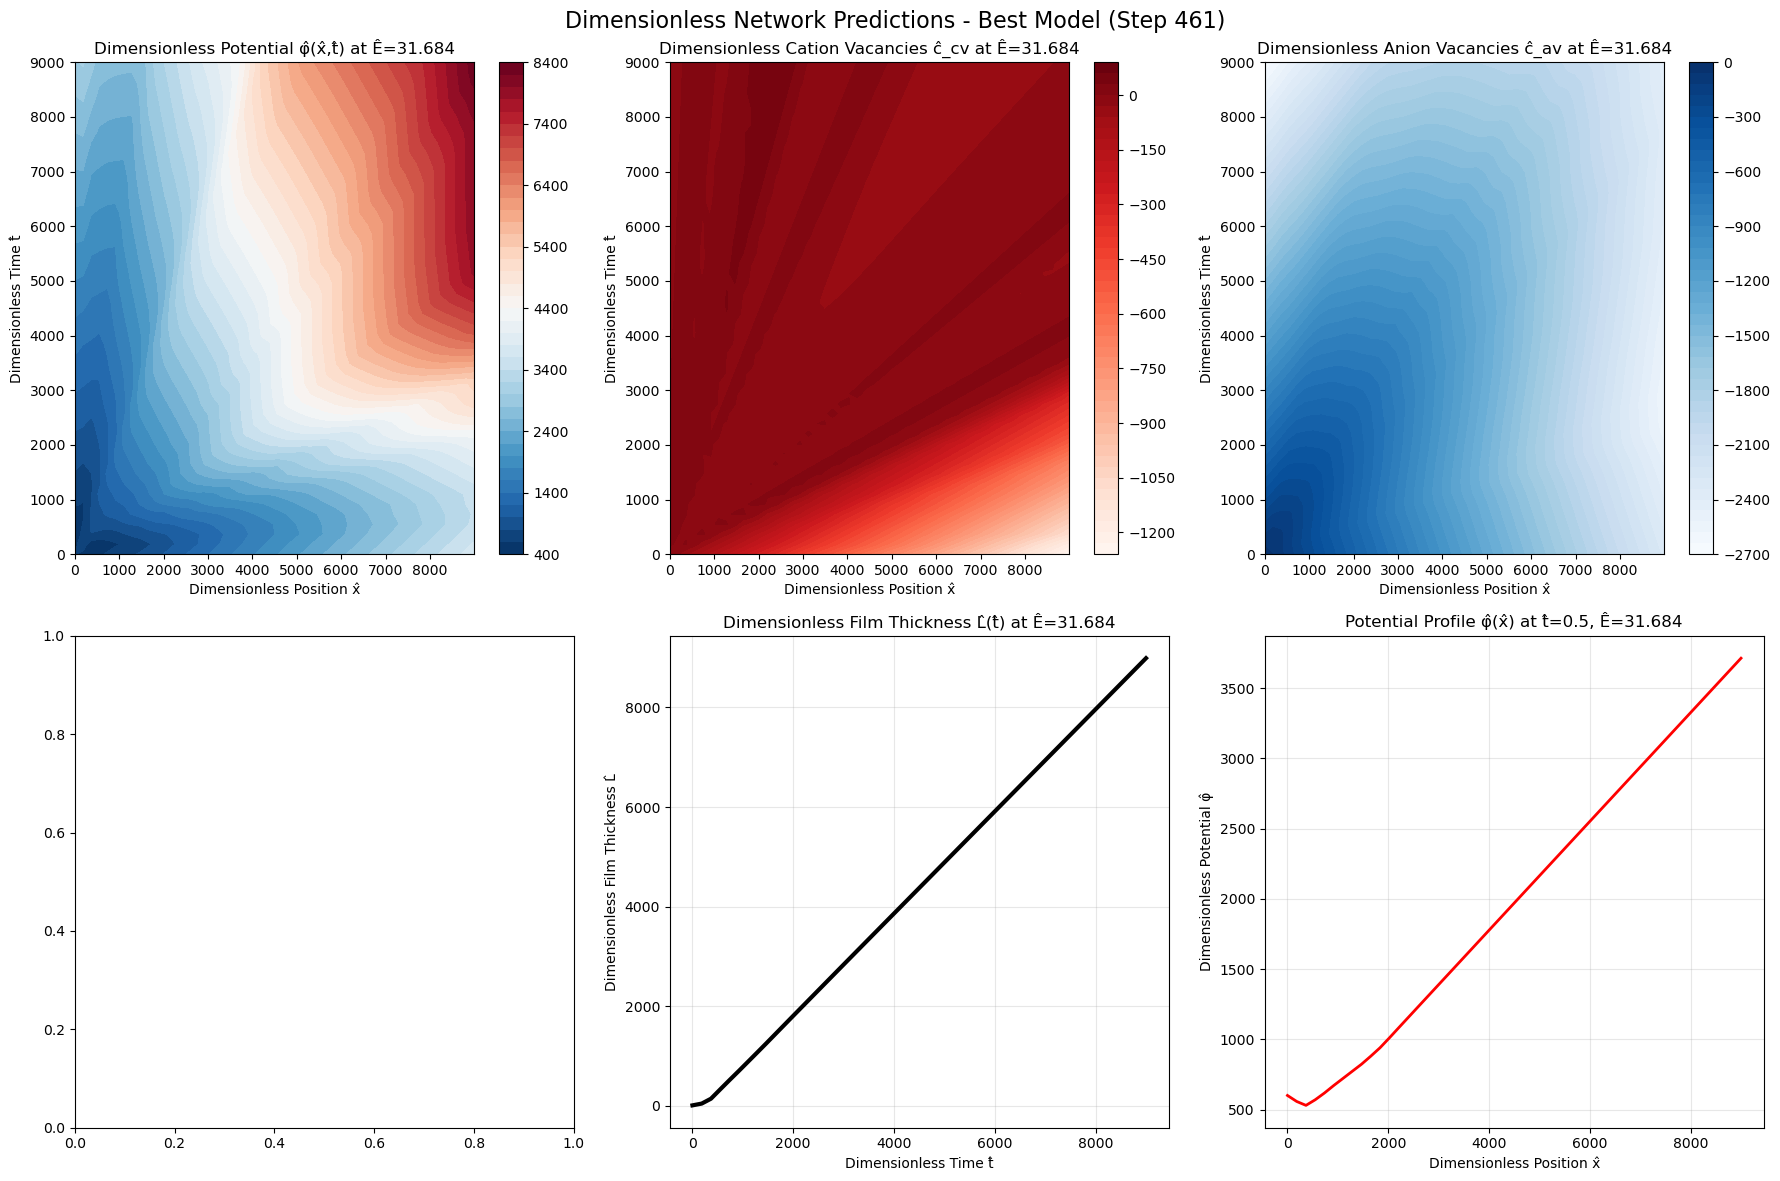

In [69]:
# ──────────────────────────────────────────────────────
# Function to load the best model for plotting
# ──────────────────────────────────────────────────────
def load_best_model():
    """Load the best saved model for inference/plotting"""
    checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pt')

    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Best model checkpoint not found at {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load state dicts into models
    cv_net.load_state_dict(checkpoint['cv_net'])
    av_net.load_state_dict(checkpoint['av_net'])
    u_net.load_state_dict(checkpoint['u_net'])
    L_net.load_state_dict(checkpoint['L_net'])

    print(f"✓ Loaded best model from step {checkpoint['step']} (loss: {checkpoint['loss']:.6f})")
    return checkpoint['step']


# ──────────────────────────────────────────────────────
# USE THIS BEFORE YOUR PLOTTING CODE
# ──────────────────────────────────────────────────────

# Load the best model
best_step = load_best_model()

# Set models to eval mode for inference
cv_net.eval()
av_net.eval()
u_net.eval()
L_net.eval()

# Now run your plotting code
with torch.no_grad():
    # Define input ranges (all dimensionless)
    n_spatial = 50
    n_temporal = 50

    # Fix a representative dimensionless potential for visualization
    E_hat_fixed = torch.tensor([[0.8 / phic]], device=device)  # Normalized E

    # Dimensionless time range (0 to 1)
    t_hat_range = torch.linspace(0, time_scale/tc, n_temporal, device=device)

    # Get final dimensionless film thickness to set spatial range
    t_hat_final = torch.tensor([[time_scale/tc]], device=device)
    L_hat_final = L_net(torch.cat([t_hat_final, E_hat_fixed], dim=1)).item()
    x_hat_range = torch.linspace(0, L_hat_final, n_spatial, device=device)

    print(f"  📐 Dimensionless time range: [0, 1.0]")
    print(f"  📐 Dimensionless spatial range: [0, {L_hat_final:.2f}]")
    print(f"  📐 Fixed dimensionless potential: {E_hat_fixed.item():.3f}")

    # Create 2D grid for contour plots
    T_hat_mesh, X_hat_mesh = torch.meshgrid(t_hat_range, x_hat_range, indexing='ij')
    E_hat_mesh = torch.full_like(T_hat_mesh, E_hat_fixed.item())

    # Stack inputs for 3D networks
    inputs_3d = torch.stack([
        X_hat_mesh.flatten(),
        T_hat_mesh.flatten(),
        E_hat_mesh.flatten()
    ], dim=1)

    # Get network predictions
    phi_hat_2d = u_net(inputs_3d).reshape(n_temporal, n_spatial)
    c_cv_hat_2d = cv_net(inputs_3d).reshape(n_temporal, n_spatial)
    c_av_hat_2d = av_net(inputs_3d).reshape(n_temporal, n_spatial)

    # Film thickness evolution (dimensionless)
    t_hat_1d = t_hat_range.unsqueeze(1)
    E_hat_1d = torch.full_like(t_hat_1d, E_hat_fixed.item())
    L_inputs_1d = torch.cat([t_hat_1d, E_hat_1d], dim=1)
    L_hat_1d = L_net(L_inputs_1d).squeeze()

    # Convert to numpy for plotting
    t_hat_np = t_hat_range.cpu().numpy()
    x_hat_np = x_hat_range.cpu().numpy()
    T_hat_np, X_hat_np = np.meshgrid(t_hat_np, x_hat_np, indexing='ij')

    phi_hat_np = phi_hat_2d.cpu().numpy()
    c_cv_hat_np = c_cv_hat_2d.cpu().numpy()
    c_av_hat_np = c_av_hat_2d.cpu().numpy()
    L_hat_np = L_hat_1d.cpu().numpy()

    # Create plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Dimensionless potential field
    im1 = axes[0, 0].contourf(X_hat_np, T_hat_np, phi_hat_np, levels=50, cmap='RdBu_r')
    axes[0, 0].set_xlabel('Dimensionless Position x̂')
    axes[0, 0].set_ylabel('Dimensionless Time t̂')
    axes[0, 0].set_title(f'Dimensionless Potential φ̂(x̂,t̂) at Ê={E_hat_fixed.item():.3f}')
    plt.colorbar(im1, ax=axes[0, 0])

    # 2. Dimensionless cation vacancies
    im2 = axes[0, 1].contourf(X_hat_np, T_hat_np, c_cv_hat_np, levels=50, cmap='Reds')
    axes[0, 1].set_xlabel('Dimensionless Position x̂')
    axes[0, 1].set_ylabel('Dimensionless Time t̂')
    axes[0, 1].set_title(f'Dimensionless Cation Vacancies ĉ_cv at Ê={E_hat_fixed.item():.3f}')
    plt.colorbar(im2, ax=axes[0, 1])

    # 3. Dimensionless anion vacancies
    im3 = axes[0, 2].contourf(X_hat_np, T_hat_np, c_av_hat_np, levels=50, cmap='Blues')
    axes[0, 2].set_xlabel('Dimensionless Position x̂')
    axes[0, 2].set_ylabel('Dimensionless Time t̂')
    axes[0, 2].set_title(f'Dimensionless Anion Vacancies ĉ_av at Ê={E_hat_fixed.item():.3f}')
    plt.colorbar(im3, ax=axes[0, 2])

    # 5. Dimensionless film thickness
    axes[1, 1].plot(t_hat_np, L_hat_np, 'k-', linewidth=3)
    axes[1, 1].set_xlabel('Dimensionless Time t̂')
    axes[1, 1].set_ylabel('Dimensionless Film Thickness L̂')
    axes[1, 1].set_title(f'Dimensionless Film Thickness L̂(t̂) at Ê={E_hat_fixed.item():.3f}')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Potential profile vs spatial position at fixed time
    x_hat_sweep = torch.linspace(0, L_hat_final, 50, device=device)
    t_hat_mid = torch.full((50, 1), 0.5, device=device)  # Middle time
    E_hat_mid = torch.full((50, 1), E_hat_fixed.item(), device=device)

    x_sweep_inputs = torch.cat([x_hat_sweep.unsqueeze(1), t_hat_mid, E_hat_mid], dim=1)
    phi_vs_x = u_net(x_sweep_inputs).cpu().numpy()

    axes[1, 2].plot(x_hat_sweep.cpu().numpy(), phi_vs_x, 'r-', linewidth=2)
    axes[1, 2].set_xlabel('Dimensionless Position x̂')
    axes[1, 2].set_ylabel('Dimensionless Potential φ̂')
    axes[1, 2].set_title(f'Potential Profile φ̂(x̂) at t̂=0.5, Ê={E_hat_fixed.item():.3f}')
    axes[1, 2].grid(True, alpha=0.3)

    plt.suptitle(f'Dimensionless Network Predictions - Best Model (Step {best_step})', fontsize=16)
    plt.tight_layout()

plt.show()

In [68]:
# #Plotting
#
# plt.figure(figsize=(12, 6))
# window=100
# # Raw loss
# plt.plot(loss_list, alpha=0.3, color='lightblue', label='Raw Loss')
#
# # Moving average for smoother trend
# if len(loss_list) > window:
#     moving_avg = np.convolve(loss_list, np.ones(window)/window, mode='valid')
#     plt.plot(range(window-1, len(loss_list)), moving_avg,
#         color='red', linewidth=2, label=f'Moving Avg ({window})')
#
# plt.yscale('log')
# plt.xlabel('Training Step', fontsize=12)
# plt.ylabel('Total Loss (log scale)', fontsize=12)
# plt.title('PINNACLE Training Loss Evolution', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.tight_layout()
#
#
# with torch.no_grad():
#     # Define input ranges (all dimensionless)
#     n_spatial = 50
#     n_temporal = 50
#
#     # Fix a representative dimensionless potential for visualization
#     E_hat_fixed = torch.tensor([[0.8 / phic]], device=device)  # Normalized E
#
#     # Dimensionless time range (0 to 1)
#     t_hat_range = torch.linspace(0, time_scale/tc, n_temporal, device=device)
#
#     # Get final dimensionless film thickness to set spatial range
#     t_hat_final = torch.tensor([[time_scale/tc]], device=device)
#     L_hat_final = L_net(torch.cat([t_hat_final, E_hat_fixed], dim=1)).item()
#     x_hat_range = torch.linspace(0, L_hat_final, n_spatial, device=device)
#
#     print(f"  📐 Dimensionless time range: [0, 1.0]")
#     print(f"  📐 Dimensionless spatial range: [0, {L_hat_final:.2f}]")
#     print(f"  📐 Fixed dimensionless potential: {E_hat_fixed.item():.3f}")
#
#     # Create 2D grid for contour plots
#     T_hat_mesh, X_hat_mesh = torch.meshgrid(t_hat_range, x_hat_range, indexing='ij')
#     E_hat_mesh = torch.full_like(T_hat_mesh, E_hat_fixed.item())
#
#     # Stack inputs for 3D networks
#     inputs_3d = torch.stack([
#     X_hat_mesh.flatten(),
#     T_hat_mesh.flatten(),
#     E_hat_mesh.flatten()
#     ], dim=1)
#
#     # Get network predictions
#     phi_hat_2d = u_net(inputs_3d).reshape(n_temporal, n_spatial)
#     c_cv_hat_2d = cv_net(inputs_3d).reshape(n_temporal, n_spatial)
#     c_av_hat_2d = av_net(inputs_3d).reshape(n_temporal, n_spatial)
#
#     # Film thickness evolution (dimensionless)
#     t_hat_1d = t_hat_range.unsqueeze(1)
#     E_hat_1d = torch.full_like(t_hat_1d, E_hat_fixed.item())
#     L_inputs_1d = torch.cat([t_hat_1d, E_hat_1d], dim=1)
#     L_hat_1d = L_net(L_inputs_1d).squeeze()
#
#     # Convert to numpy for plotting
#     t_hat_np = t_hat_range.cpu().numpy()
#     x_hat_np = x_hat_range.cpu().numpy()
#     T_hat_np, X_hat_np = np.meshgrid(t_hat_np, x_hat_np, indexing='ij')
#
#     phi_hat_np = phi_hat_2d.cpu().numpy()
#     c_cv_hat_np = c_cv_hat_2d.cpu().numpy()
#     c_av_hat_np = c_av_hat_2d.cpu().numpy()
#     L_hat_np = L_hat_1d.cpu().numpy()
#
#     # Create plots
#     fig, axes = plt.subplots(2, 3, figsize=(18, 12))
#
#     # 1. Dimensionless potential field
#     im1 = axes[0, 0].contourf(X_hat_np, T_hat_np, phi_hat_np, levels=50, cmap='RdBu_r')
#     axes[0, 0].set_xlabel('Dimensionless Position x̂')
#     axes[0, 0].set_ylabel('Dimensionless Time t̂')
#     axes[0, 0].set_title(f'Dimensionless Potential φ̂(x̂,t̂) at Ê={E_hat_fixed.item():.3f}')
#     plt.colorbar(im1, ax=axes[0, 0])
#
#     # 2. Dimensionless cation vacancies
#     im2 = axes[0, 1].contourf(X_hat_np, T_hat_np, c_cv_hat_np, levels=50, cmap='Reds')
#     axes[0, 1].set_xlabel('Dimensionless Position x̂')
#     axes[0, 1].set_ylabel('Dimensionless Time t̂')
#     axes[0, 1].set_title(f'Dimensionless Cation Vacancies ĉ_cv at Ê={E_hat_fixed.item():.3f}')
#     plt.colorbar(im2, ax=axes[0, 1])
#
#     # 3. Dimensionless anion vacancies
#     im3 = axes[0, 2].contourf(X_hat_np, T_hat_np, c_av_hat_np, levels=50, cmap='Blues')
#     axes[0, 2].set_xlabel('Dimensionless Position x̂')
#     axes[0, 2].set_ylabel('Dimensionless Time t̂')
#     axes[0, 2].set_title(f'Dimensionless Anion Vacancies ĉ_av at Ê={E_hat_fixed.item():.3f}')
#     plt.colorbar(im3, ax=axes[0, 2])
#
#     # 5. Dimensionless film thickness
#     axes[1, 1].plot(t_hat_np, L_hat_np, 'k-', linewidth=3)
#     axes[1, 1].set_xlabel('Dimensionless Time t̂')
#     axes[1, 1].set_ylabel('Dimensionless Film Thickness L̂')
#     axes[1, 1].set_title(f'Dimensionless Film Thickness L̂(t̂) at Ê={E_hat_fixed.item():.3f}')
#     axes[1, 1].grid(True, alpha=0.3)
#
#     # 6. Potential profile vs spatial position at fixed time
#     x_hat_sweep = torch.linspace(0, L_hat_final, 50, device=device)
#     t_hat_mid = torch.full((50, 1), 0.5, device=device)  # Middle time
#     E_hat_mid = torch.full((50, 1), E_hat_fixed.item(), device=device)
#
#     x_sweep_inputs = torch.cat([x_hat_sweep.unsqueeze(1), t_hat_mid, E_hat_mid], dim=1)
#     phi_vs_x = u_net(x_sweep_inputs).cpu().numpy()
#
#     axes[1, 2].plot(x_hat_sweep.cpu().numpy(), phi_vs_x, 'r-', linewidth=2)
#     axes[1, 2].set_xlabel('Dimensionless Position x̂')
#     axes[1, 2].set_ylabel('Dimensionless Potential φ̂')
#     axes[1, 2].set_title(f'Potential Profile φ̂(x̂) at t̂=0.5, Ê={E_hat_fixed.item():.3f}')
#     axes[1, 2].grid(True, alpha=0.3)
#
#     plt.suptitle(f'Dimensionless Network Predictions Overview - Step {step}', fontsize=16)
#     plt.tight_layout()
#
#
#
# plt.show()